# **Graph Neural Networks**

Es un tipo de modelo de aprendizaje automático diseñado para trabajar con datos estructurados en forma de grafos. A diferencia de las redes neuronales convencionales que trabajan con datos tabulares o imágenes, las GCN permiten el procesamiento de información en grafos, lo que las hace especialmente útiles en aplicaciones donde las relaciones y conexiones entre los elementos son importantes.

En un grafo, los elementos se representan como nodos (también conocidos como vértices) y las relaciones entre ellos se representan como aristas (también conocidas como edges). Esto podría aplicarse a diversas situaciones del mundo real, como redes sociales, sistemas de recomendación, análisis de proteínas o mapeo de rutas.

El objetivo principal de una GCN es aprender representaciones de nodos que capturen tanto la información local del nodo como la información global del grafo. Esto se logra propagando y combinando información a través de las aristas del grafo. Es decir, cada nodo se actualiza teniendo en cuenta no solo sus características propias, sino también las características de los nodos vecinos.

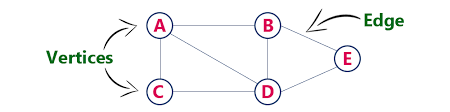

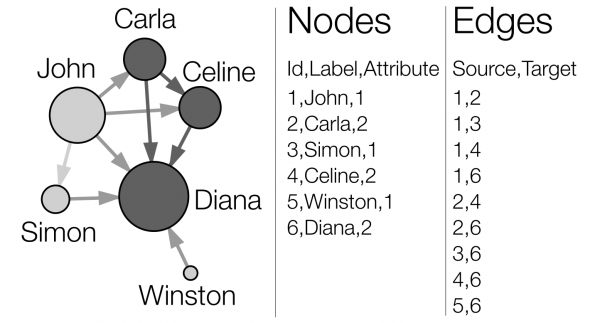

**PyTorch Geometric** es una biblioteca de extensión del popular marco de aprendizaje profundo PyTorch y consta de varios métodos y utilidades para facilitar la implementación de redes neuronales gráficas.

Siguiendo a Kipf et al. (2017), vamos a tener un primer acercamiento a estas redes con un ejemplo sencillo, la conocida red del club de kárate de Zachary. Este gráfico describe una red social de 34 miembros de un club de kárate y muestra los vínculos entre los miembros que interactuaron fuera del club. **En este caso, nos interesa detectar las comunidades que surgen de la interacción de los miembros.**

En este contexto, el objetivo general de las redes neuronales gráficas (GNN) es generalizar los conceptos clásicos de aprendizaje profundo a datos estructurados irregulares (en contraste con imágenes o textos) y permitir que las redes neuronales razonen sobre los objetos y sus relaciones.

In [ ]:
!pip install -q torch-geometric

In [ ]:
# Paquetes para visualiación
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def visualize_graph(G, color):  # Función para visualizar grafos
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

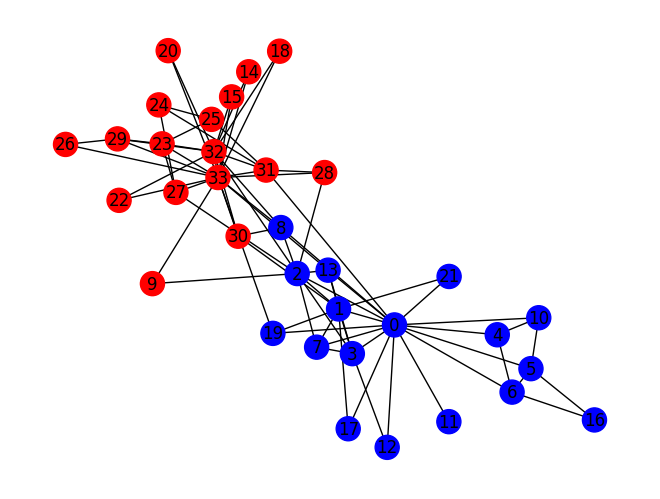

In [ ]:
#@title ## Visualización de datos

# Cargar el conjunto de datos Karate Club como grafo
G = nx.karate_club_graph()

# Obtener las etiquetas de facción para cada nodo
labels = {node: data['club'] for node, data in G.nodes(data=True)}

# Definir colores para cada facción
colors = ['blue' if label == 'Mr. Hi' else 'red' for label in labels.values()]

# Visualizar el grafo con colores según las facciones
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

In [ ]:
#@title ## ¿A que club pertenece cada nodo?
for node, data in G.nodes(data=True):
  print(data,node)

{'club': 'Mr. Hi'} 0
{'club': 'Mr. Hi'} 1
{'club': 'Mr. Hi'} 2
{'club': 'Mr. Hi'} 3
{'club': 'Mr. Hi'} 4
{'club': 'Mr. Hi'} 5
{'club': 'Mr. Hi'} 6
{'club': 'Mr. Hi'} 7
{'club': 'Mr. Hi'} 8
{'club': 'Officer'} 9
{'club': 'Mr. Hi'} 10
{'club': 'Mr. Hi'} 11
{'club': 'Mr. Hi'} 12
{'club': 'Mr. Hi'} 13
{'club': 'Officer'} 14
{'club': 'Officer'} 15
{'club': 'Mr. Hi'} 16
{'club': 'Mr. Hi'} 17
{'club': 'Officer'} 18
{'club': 'Mr. Hi'} 19
{'club': 'Officer'} 20
{'club': 'Mr. Hi'} 21
{'club': 'Officer'} 22
{'club': 'Officer'} 23
{'club': 'Officer'} 24
{'club': 'Officer'} 25
{'club': 'Officer'} 26
{'club': 'Officer'} 27
{'club': 'Officer'} 28
{'club': 'Officer'} 29
{'club': 'Officer'} 30
{'club': 'Officer'} 31
{'club': 'Officer'} 32
{'club': 'Officer'} 33


In [ ]:
import pandas as pd # Para crear el dataframe

# Cargar el conjunto de datos Karate Club
G = nx.karate_club_graph()

# Crear un DataFrame a partir de los datos del grafo
df = pd.DataFrame(list(G.edges()), columns=['Nodo 1', 'Nodo 2'])

# Imprimir el DataFrame
print(df)

    Nodo 1  Nodo 2
0        0       1
1        0       2
2        0       3
3        0       4
4        0       5
..     ...     ...
73      30      32
74      30      33
75      31      32
76      31      33
77      32      33

[78 rows x 2 columns]


### **Un poco más información de dataset**
Después de inicializar el conjunto de datos KarateClub, podemos inspeccionar algunas de sus propiedades. Por ejemplo, podemos ver que este conjunto de datos contiene exactamente un grafo y que a cada nodo se le asigna un vector de características de 34 dimensiones que describe de forma única a los miembros del club de kárate. Además, el gráfico contiene cuatro clases, que representan la comunidad a la que pertenece cada nodo.

In [ ]:
from torch_geometric.datasets import KarateClub # Importante KarateClub desde torch geometric

dataset = KarateClub() # Llamo dataset a KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [ ]:
data = dataset[0]  # Llamo al primer elemento de dataset

print(data)
print('==============================================================')

# Algunas estadísticas sobre el gráfico.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Tenemos un pequeño resumen de la información del grafo en la siguiente linea
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
Podemos ver que este objeto de datos contiene cuatro atributos:
(1) La propiedad **edge_index** contiene la información sobre la conectividad del grafo, es decir, una tupla de índices de nodos de origen y destino para cada borde. Las **características de los nodos** (2) como x (a cada uno de los 34 nodos se le asigna un vector de características de 34 dimensiones), y a las **etiquetas de los nodos** (3) como y (a cada nodo se le asigna exactamente una clase).
También existe un atributo adicional llamado **train_mask**, que describe para qué nodos ya conocemos sus asignaciones de comunidad. En total, solo conocemos las etiquetas de verdad fundamental de cuatro nodos (una para cada comunidad), por lo que la tarea consiste en inferir la asignación de comunidad para los nodos restantes.

In [ ]:
#@title ## Podemos apreciar las interconecciones presentes en "edge_index"
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

Podemos visualizar el gráfico aún más convirtiéndolo al formato de la biblioteca NetworkX, que implementa, además de funcionalidades de manipulación de gráficos, potentes herramientas de visualización.

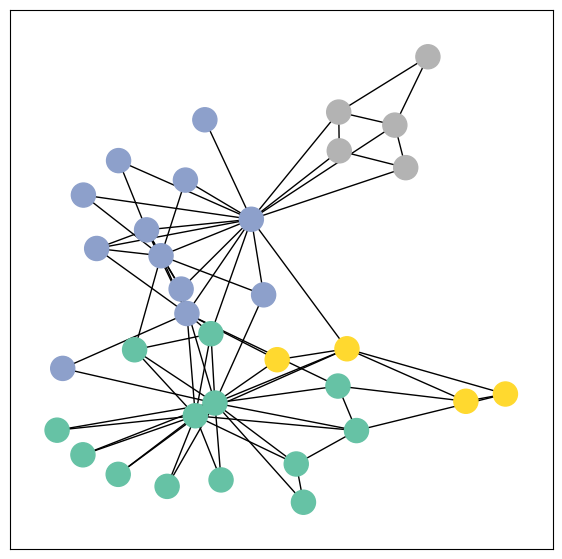

In [ ]:
from torch_geometric.utils import to_networkx # Llamamos a networkX

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

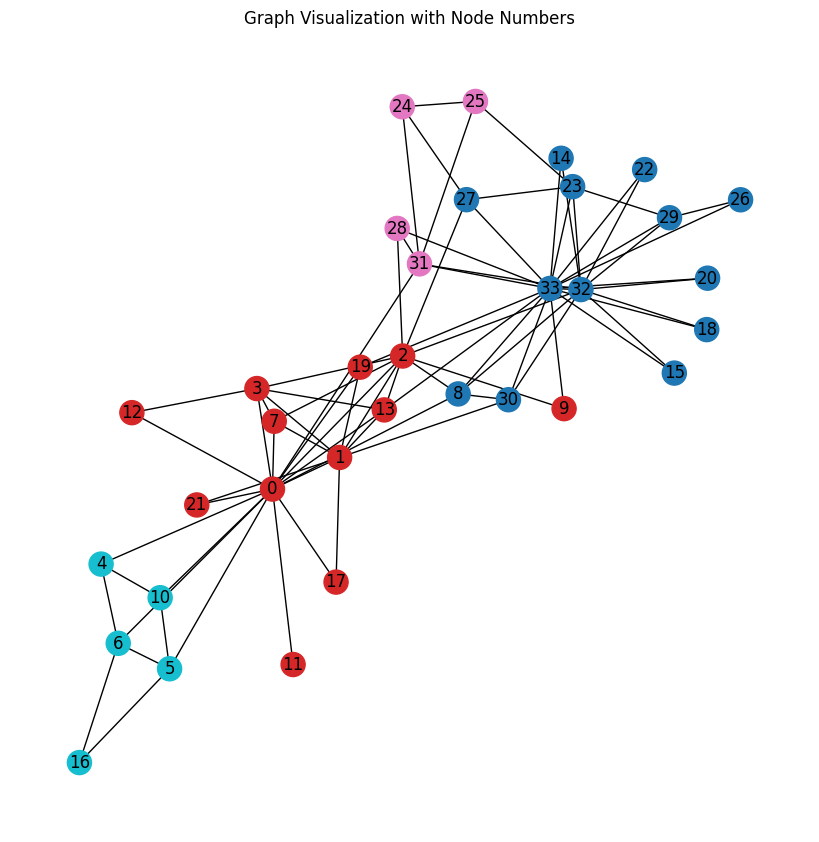

In [ ]:
# Convertir el objeto de datos a un grafo NetworkX
G = to_networkx(data, to_undirected=True)

# Crear un diccionario de etiquetas con los números de nodo
node_labels = {node: str(node) for node in G.nodes}

# Visualizar el grafo con etiquetas de nodos
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  # Layout del grafo
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=300, node_color=data.y, cmap=plt.cm.tab10)
plt.title("Graph Visualization with Node Numbers")
plt.show()

## **Implementación de una\ Graph Neural Networks**

In [ ]:
#@title # Cargando módulos necesarios
import torch
from torch_geometric.nn import GCNConv
from torch.nn import Linear

## **Modelo 1**

## Definiendo la clase GCN

In [ ]:
class GCN_1(torch.nn.Module): # Definimos la clase GCN
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)  # Seteamos una semilla.
        self.conv1 = GCNConv(dataset.num_features, 4) # Capa conv 1
        self.conv2 = GCNConv(4, 4) # Capa conv 2
        self.conv3 = GCNConv(4, 2) # Capa conv 3
        self.classifier = Linear(2, dataset.num_classes) # Capa linear de salida. Realiza las predicciones

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()   # Función de activación
        h = self.conv2(h, edge_index)
        h = h.relu() # Función de activación
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.

       # Aplicar un clasificador final (lineal).
        out = self.classifier(h)

        return out, h  # Devuelve la predicción y el embedding space


In [ ]:
model_1 = GCN_1()  # llamamos model_1
print(model_1)   # Permite visualizar la estructura de nuestra red

GCN_1(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


En primer lugar, inicializamos todos nuestros bloques de construcción en __init__ y definimos el flujo de cómputo de nuestra red a partir de ese momento. Primero definimos y apilamos tres capas de convolución del grafo. Además, las capas GCNConv reducen la dimensionalidad de las características del nodo a 2, es decir, 34 → 4 → 4 → 2.

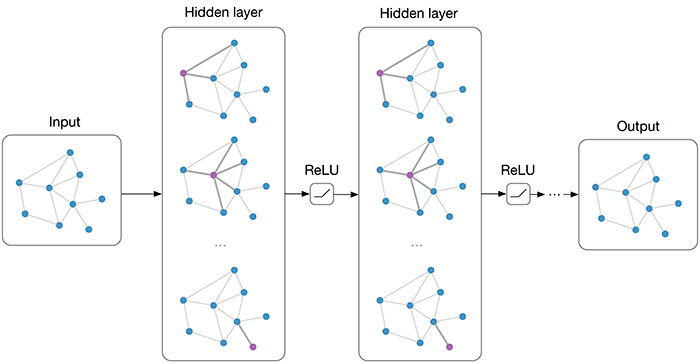

Vamos a buscar entrenar el modelo de forma que en base a las interconecciones logre predecir a que clase pertenece cada nodo.
En primera instancia podemos ver como clasifica nuestra red a los nodos sin ningún entrenamiento

Embedding shape: [34, 2]


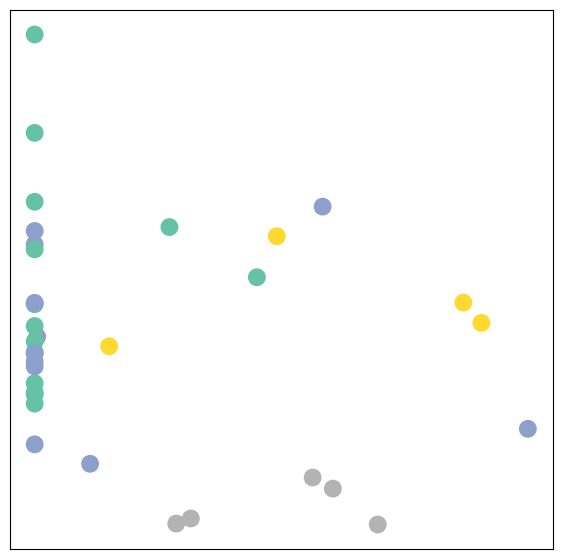

In [ ]:
_, h = model_1(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

La performance no fue muy buena ya que podemos apreciar que no logró agrupar a los nodos de la misma clase (mismo color) lo suficientemente bien

## Entrenando el modelo

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model_1 = GCN_1()
criterion = torch.nn.CrossEntropyLoss()  # Define la función de perdida.
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)  # Define optimizador.

def train(data,model): # Función de entrenamiento. Le damos de entrada los datos y el modelo a entrenar
    optimizer.zero_grad()  # limpia los gradientes.
    out, h = model(data.x, data.edge_index)  # realiza una predicción
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Calcula la pérdida basándose únicamente en los nodos de entrenamiento.
    loss.backward()  # aplica el backward
    optimizer.step()  # Actualizar parámetros en función de gradientes.
    return loss, h # Devuelve la perdida calculada y el embedding

<IPython.core.display.Javascript object>

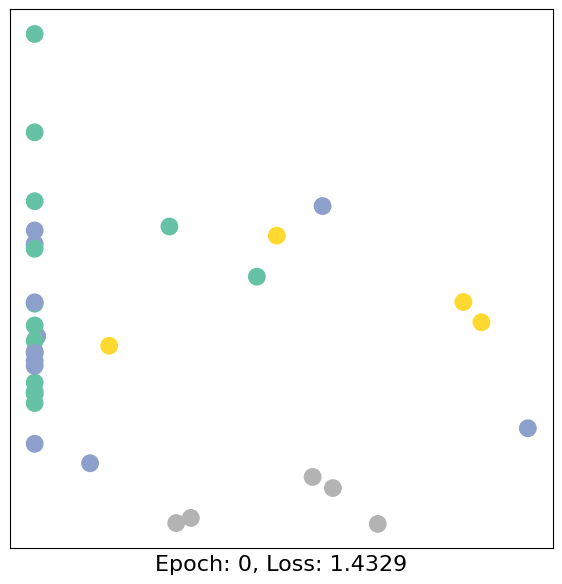

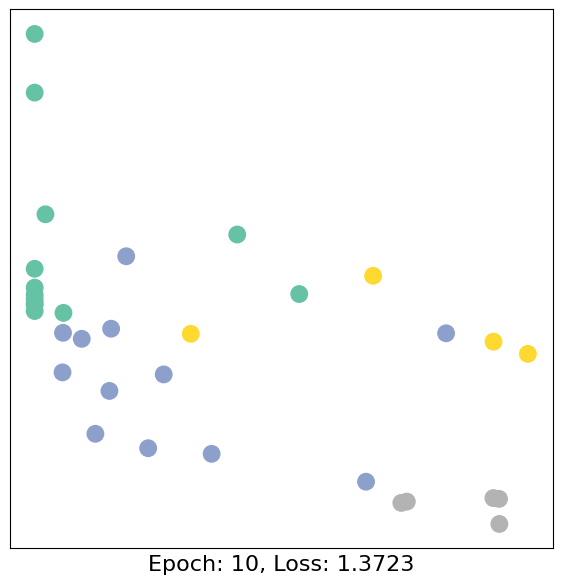

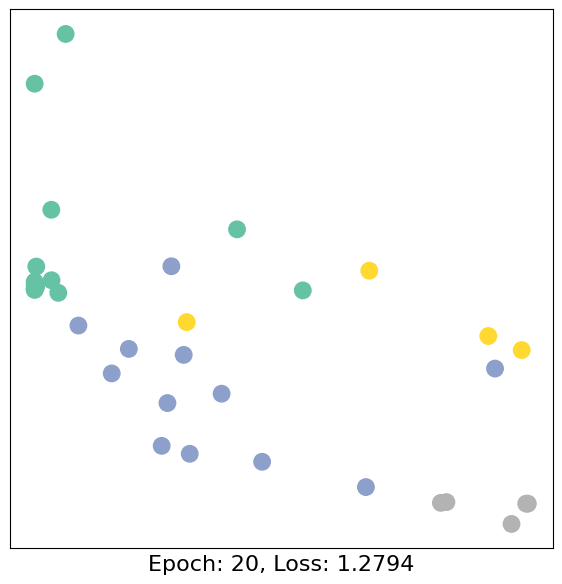

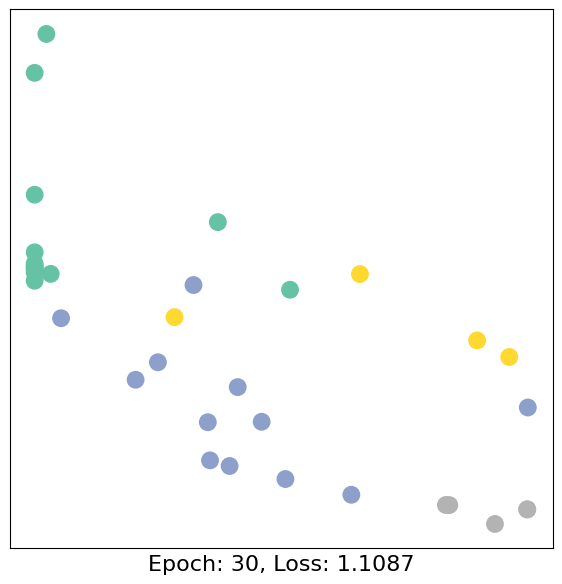

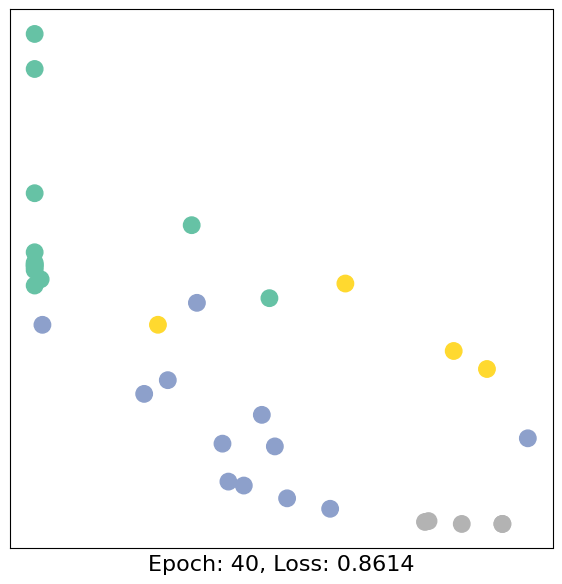

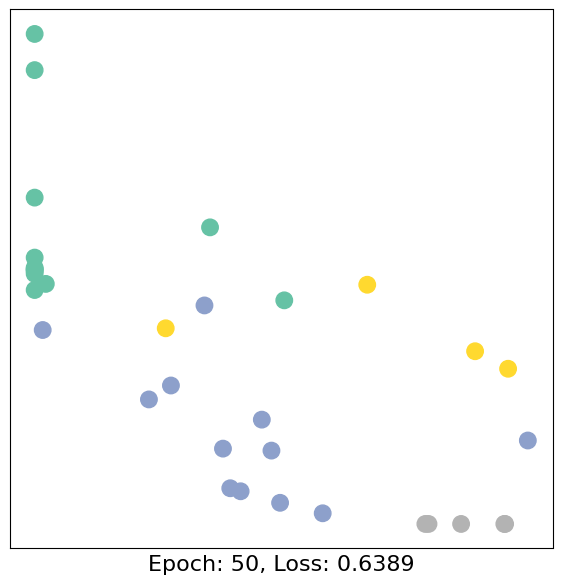

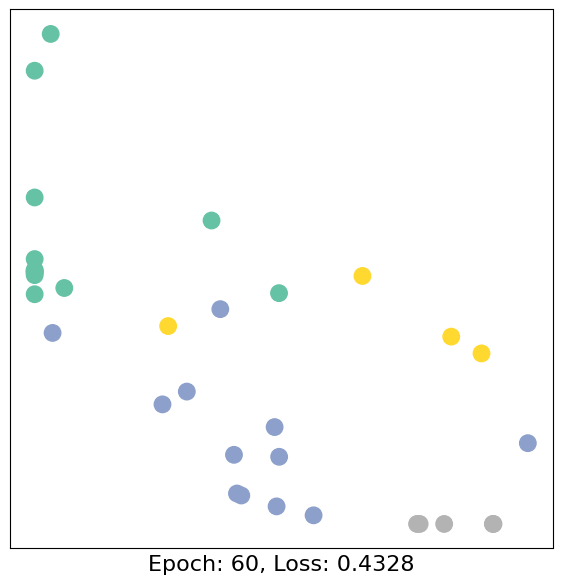

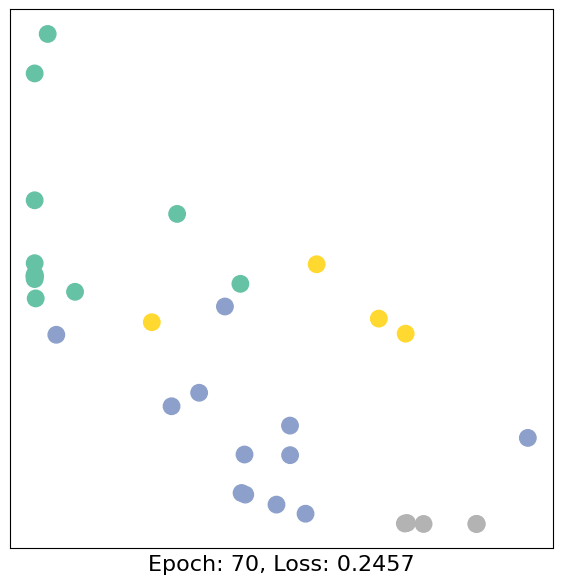

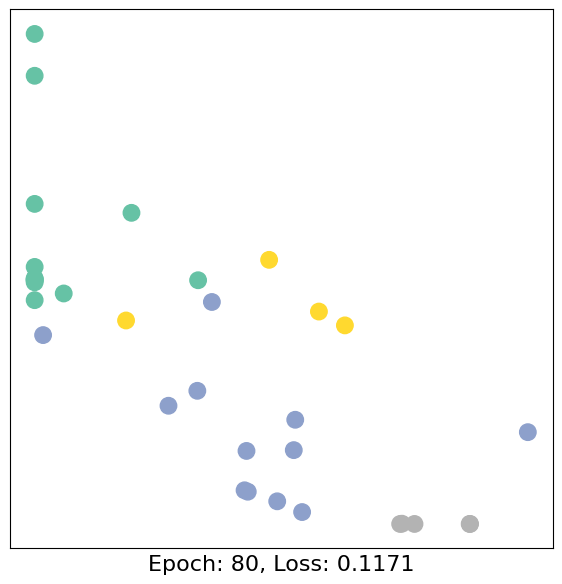

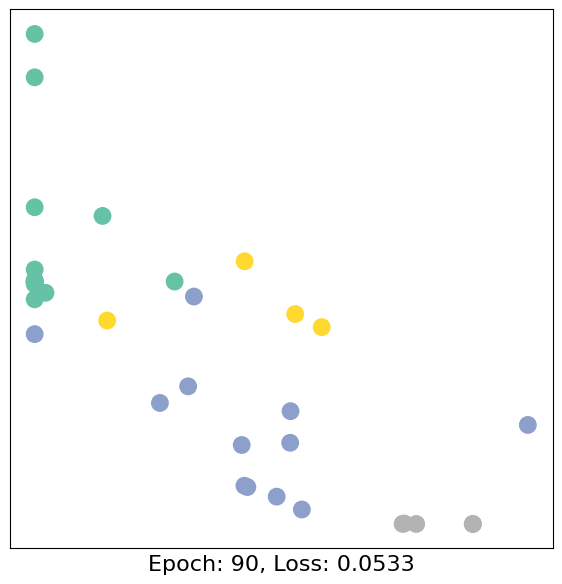

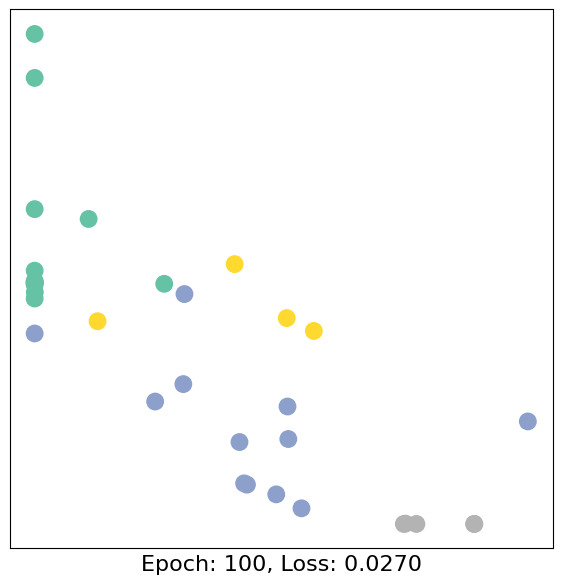

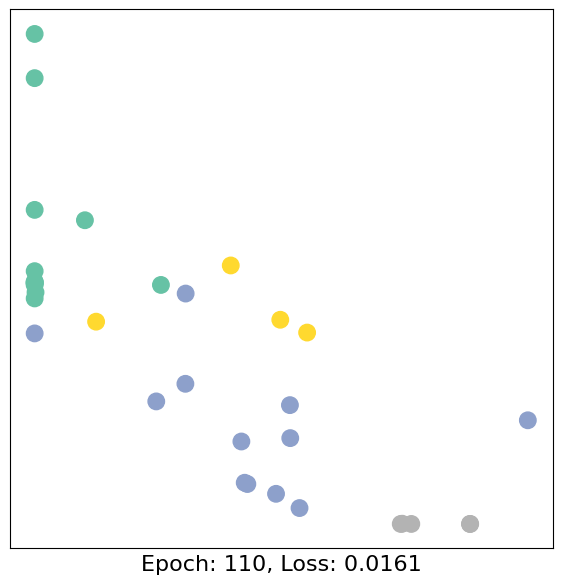

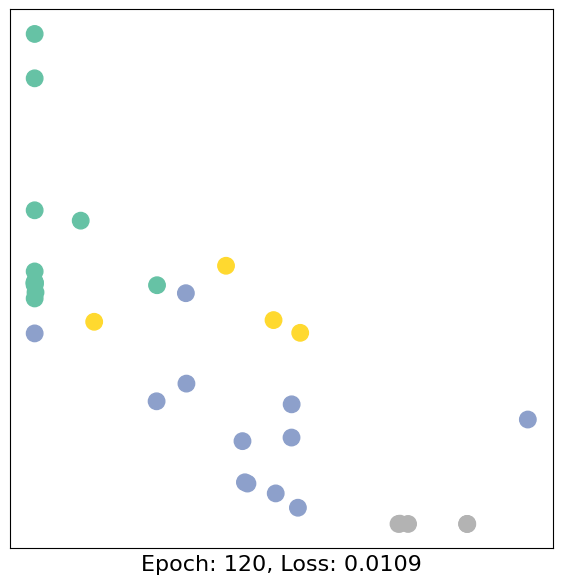

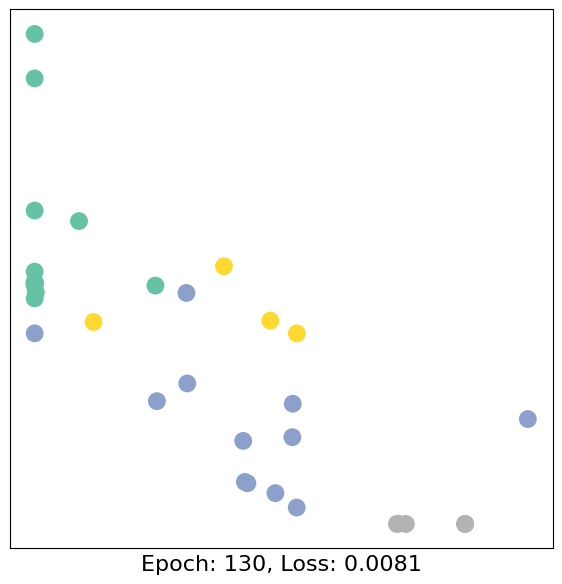

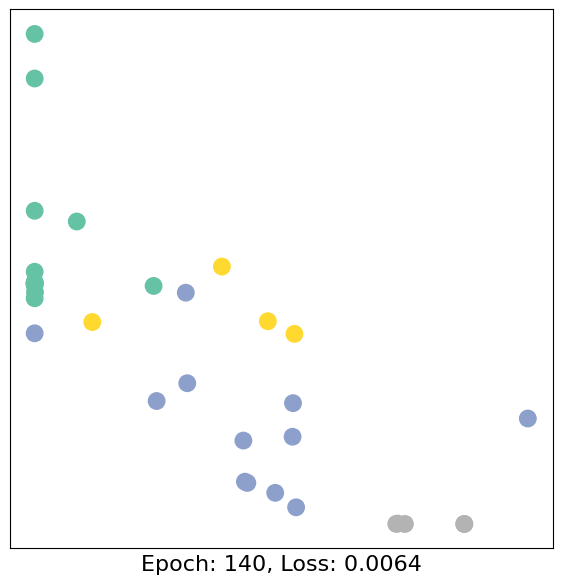

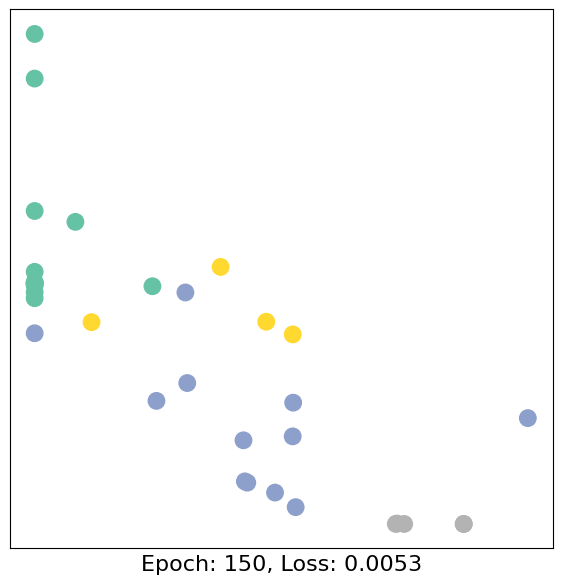

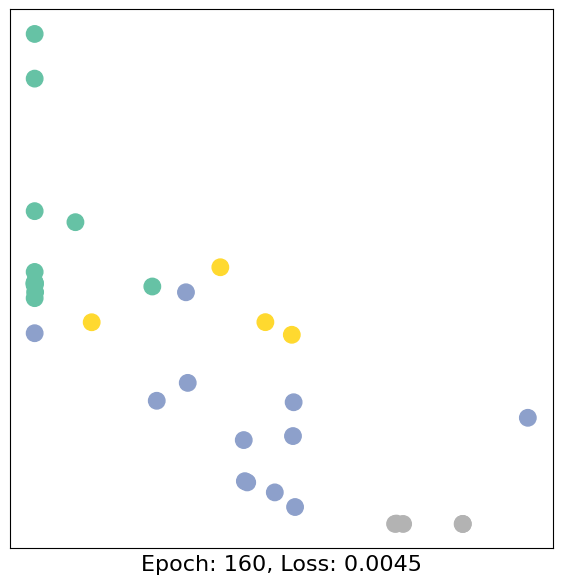

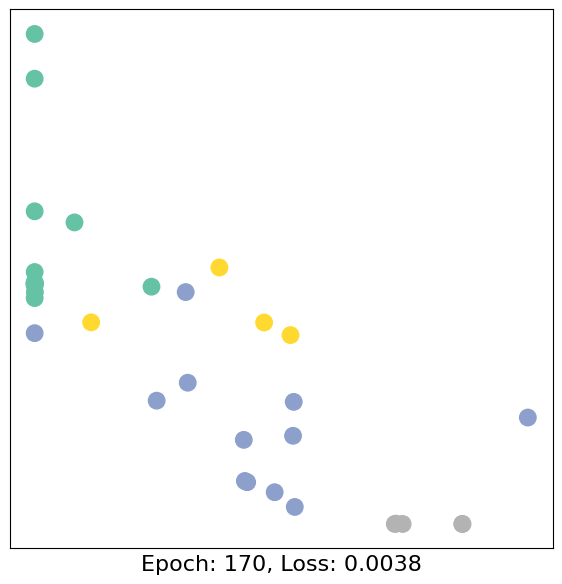

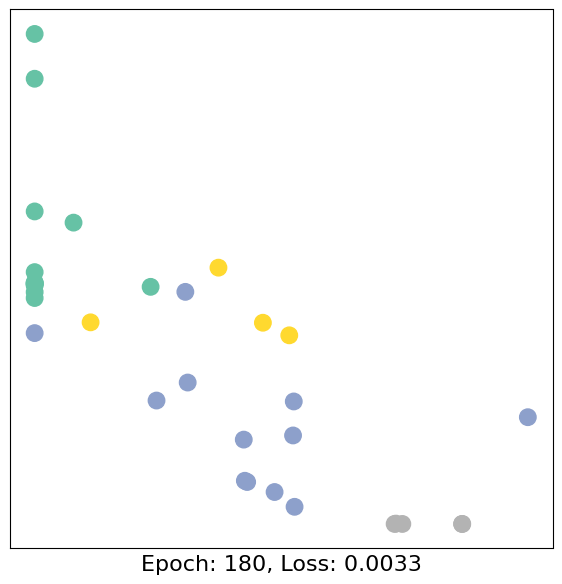

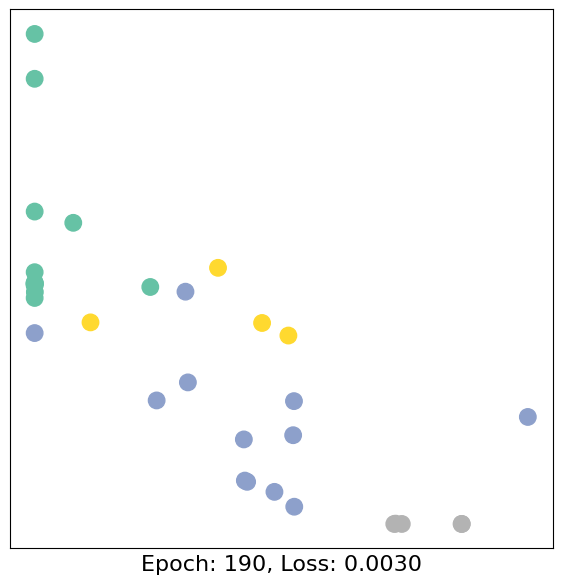

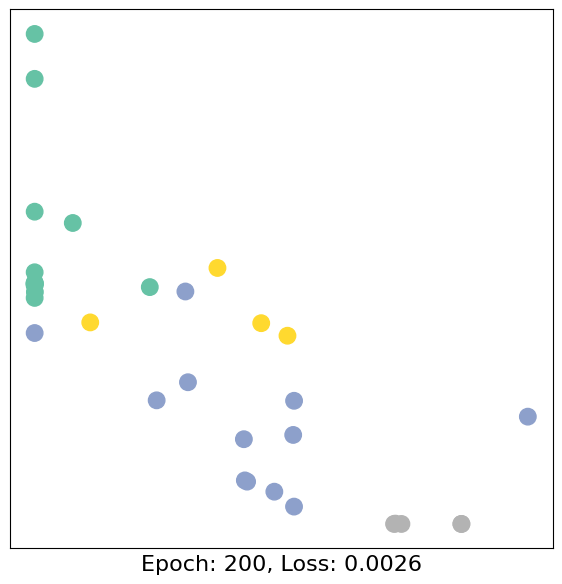

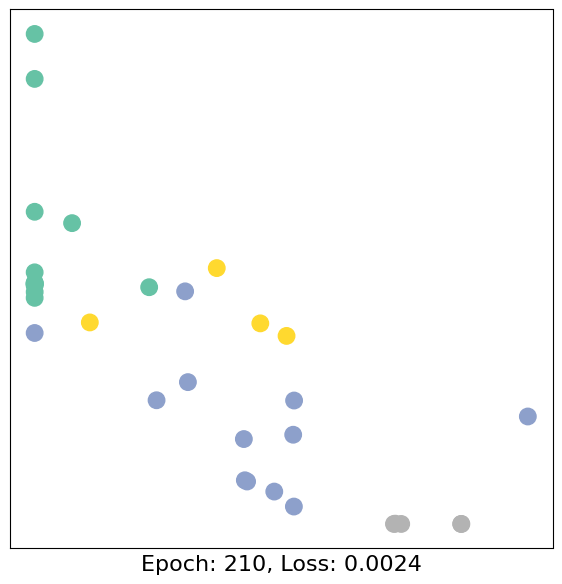

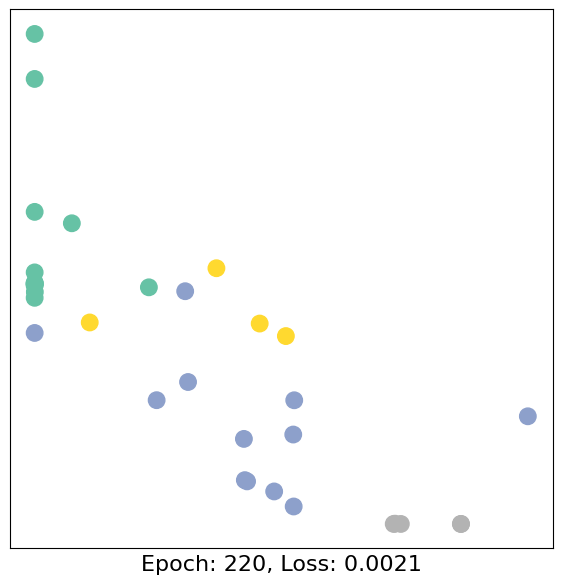

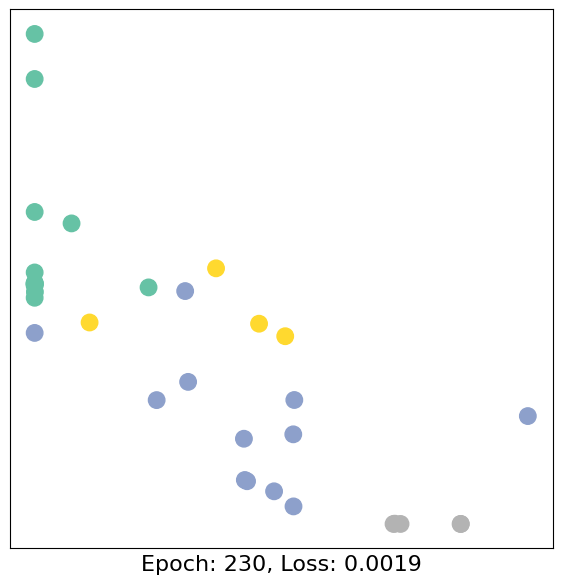

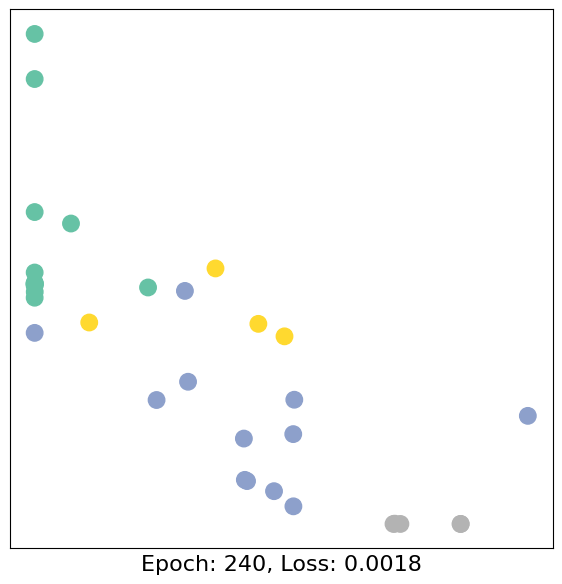

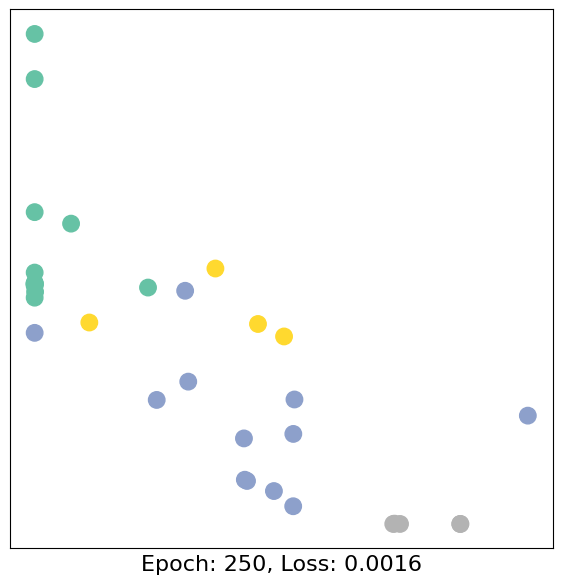

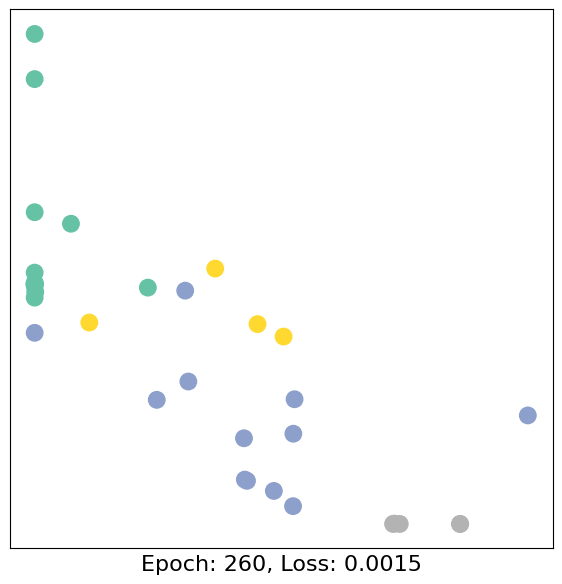

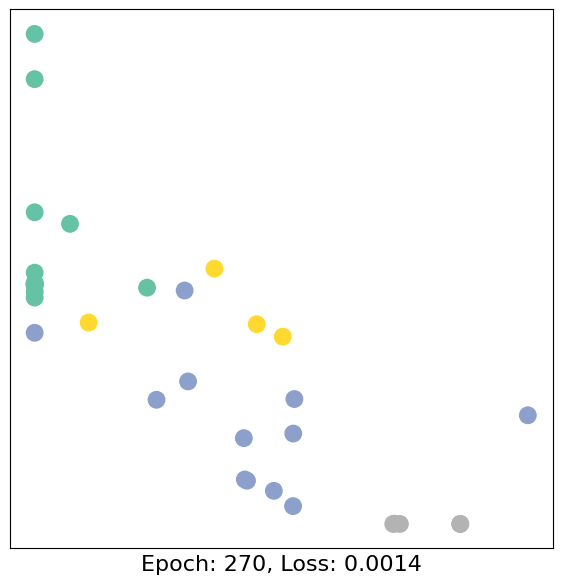

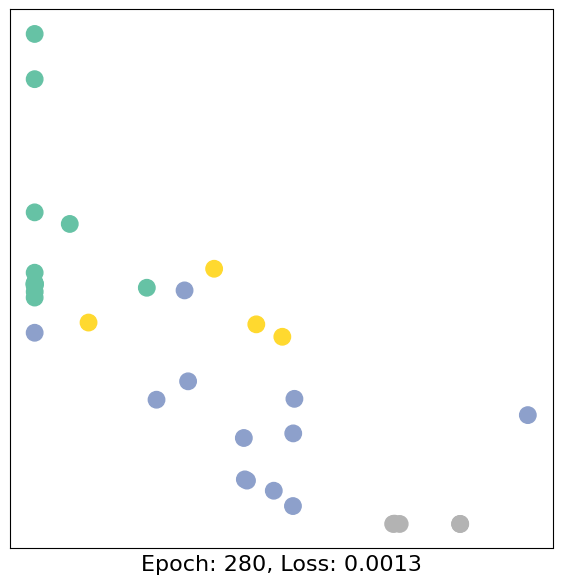

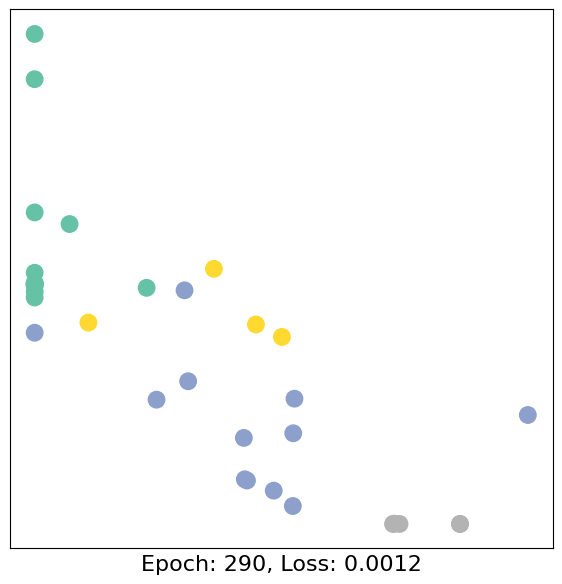

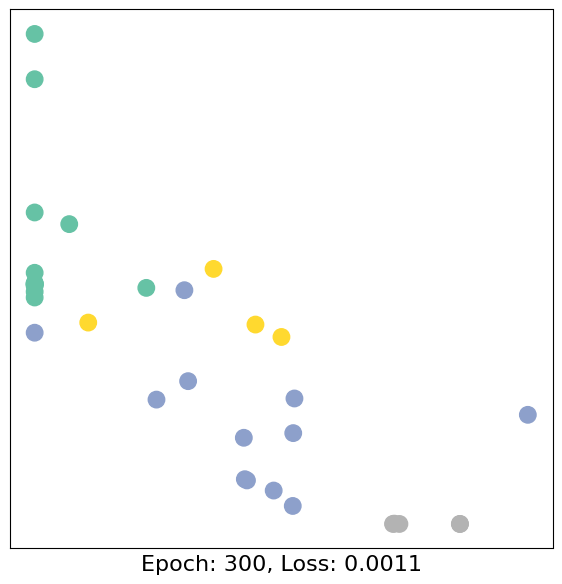

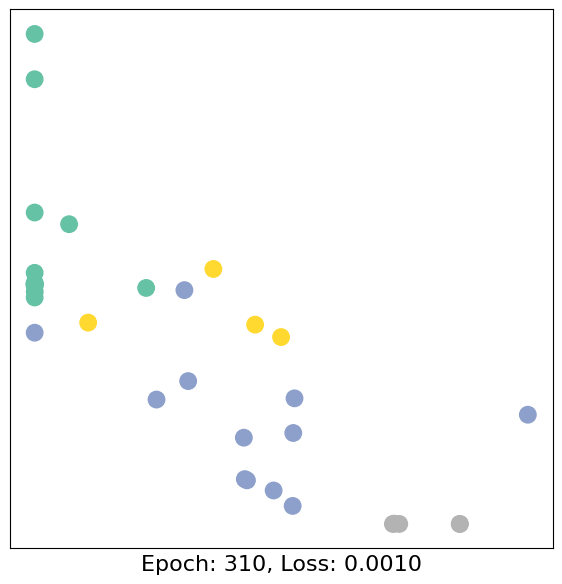

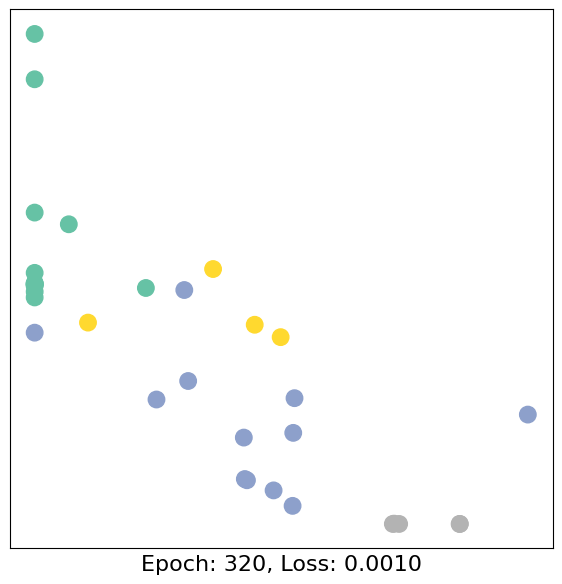

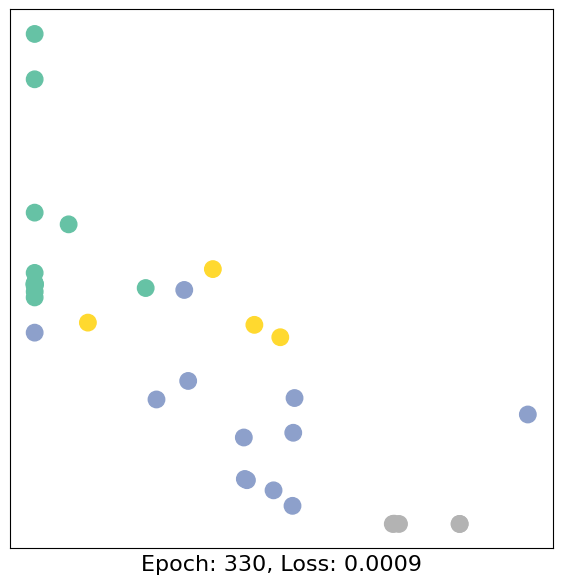

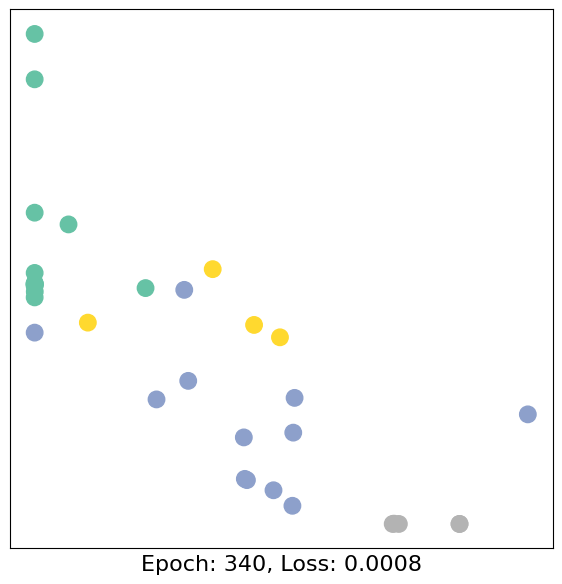

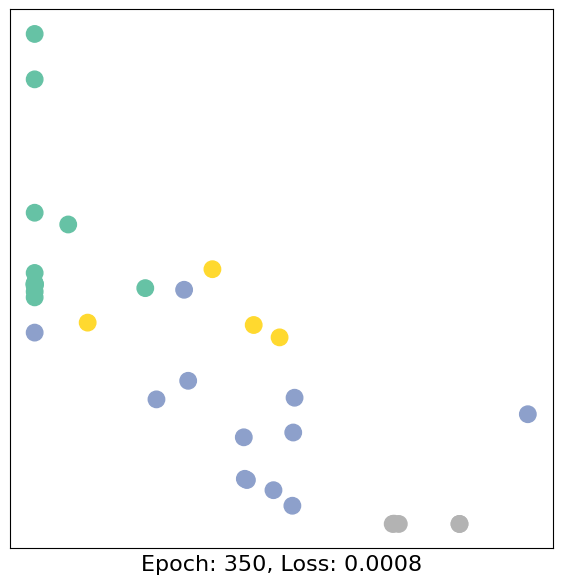

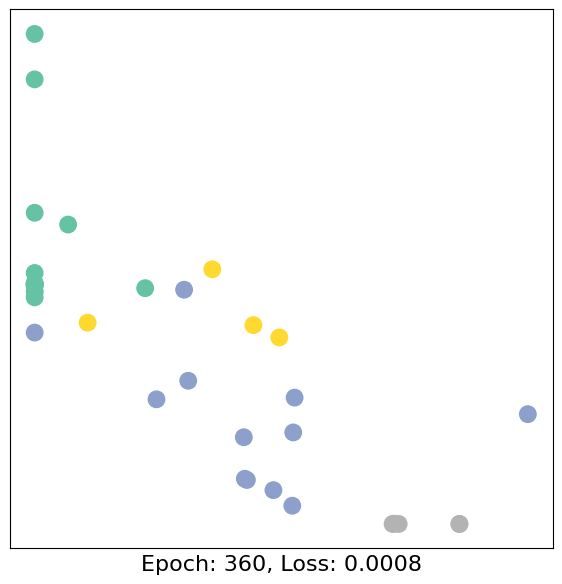

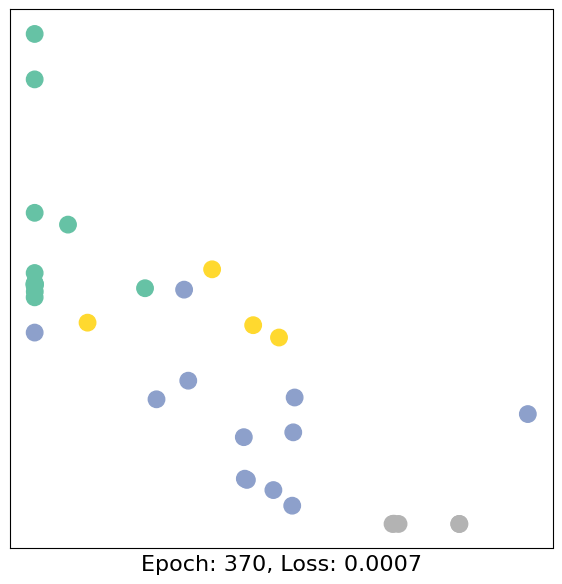

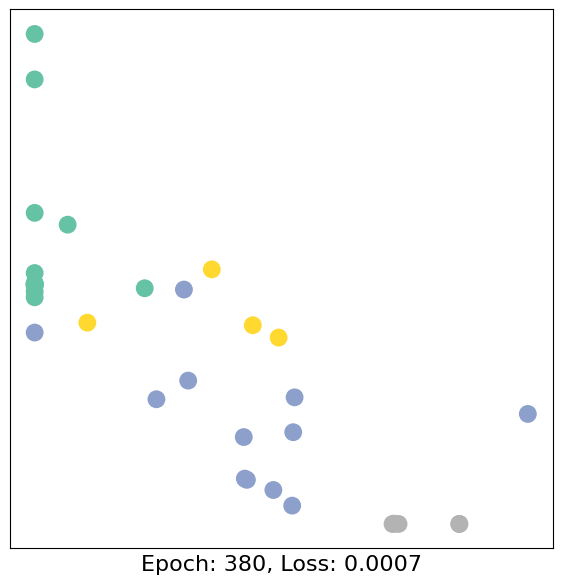

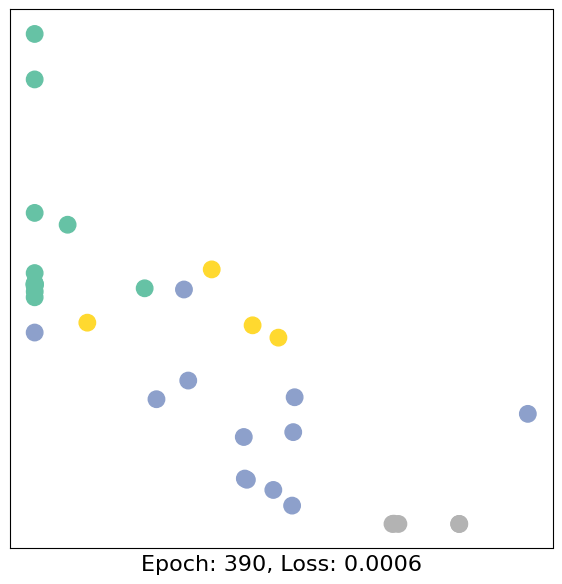

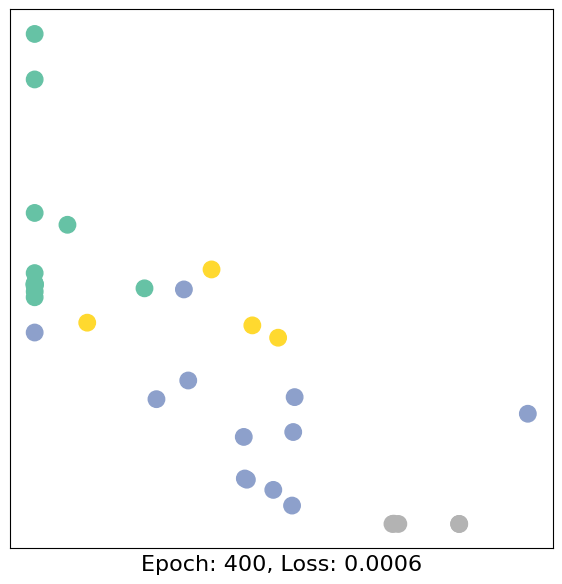

In [ ]:
epochs = []  # Lista para almacenar las épocas
losses = []  # Lista para almacenar las pérdidas
for epoch in range(401):  # Entrenamos el modelo por 400 épocas
    loss, h = train(data,model_1)  # Llamamos a la función de entrenamiento
    losses.append(float(loss))  # Almacenamos la pérdida en la lista
    epochs.append(epoch)  # Almacenamos la época en la lista
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)



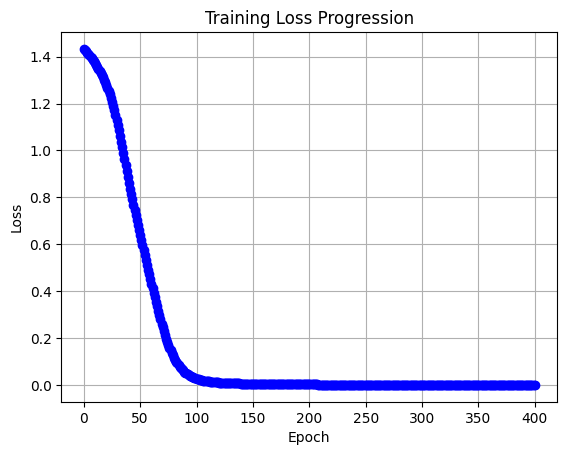

In [ ]:
plt.figure()  # Gráfica de la pérdida en función de las épocas
plt.plot(epochs, losses, marker='o', color='b')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## **Modelo 2**

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


In [ ]:
model_2 = GCN_2()
print(model_2)

GCN_2(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


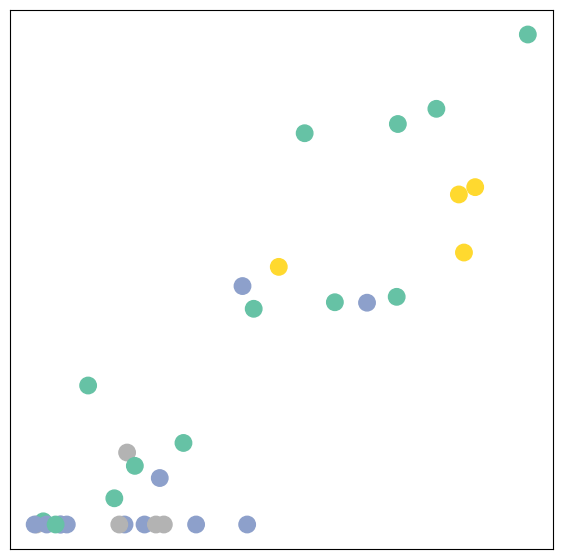

In [ ]:
model_2 = GCN_2()

_, h = model_2(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

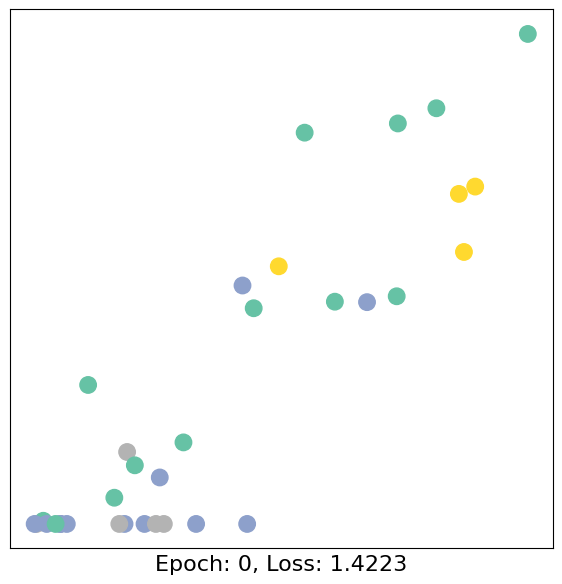

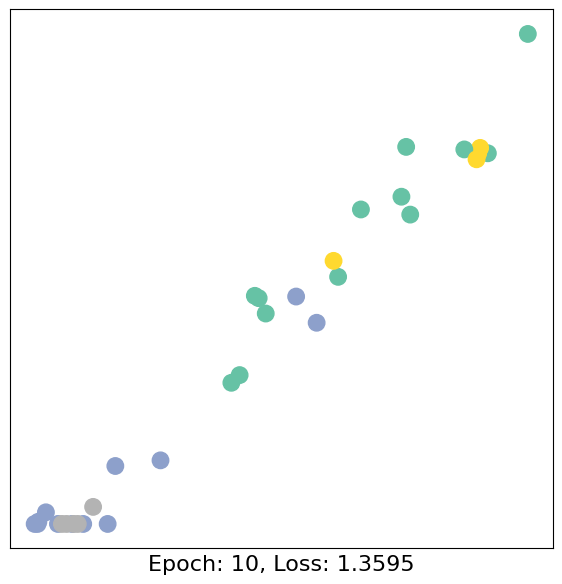

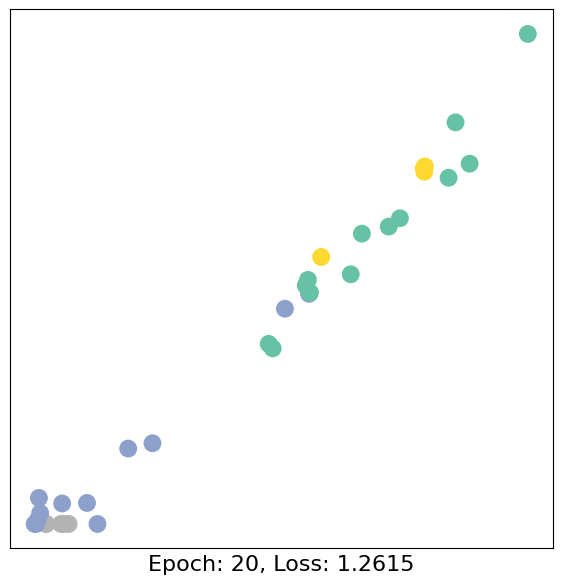

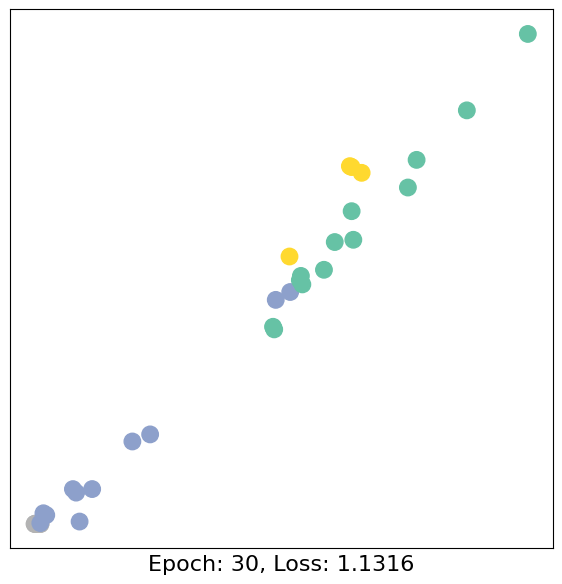

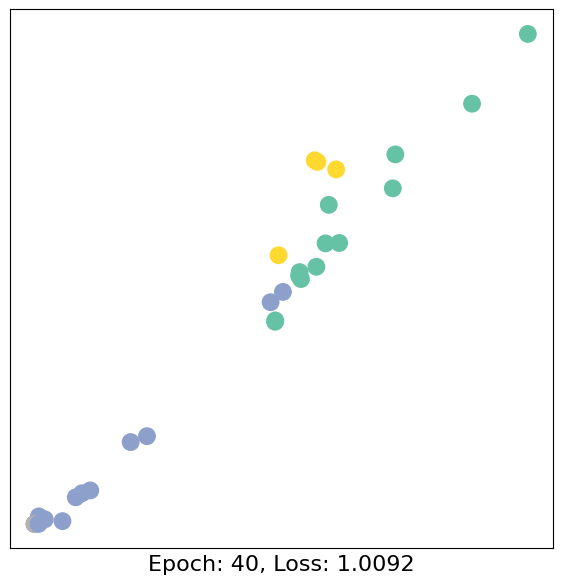

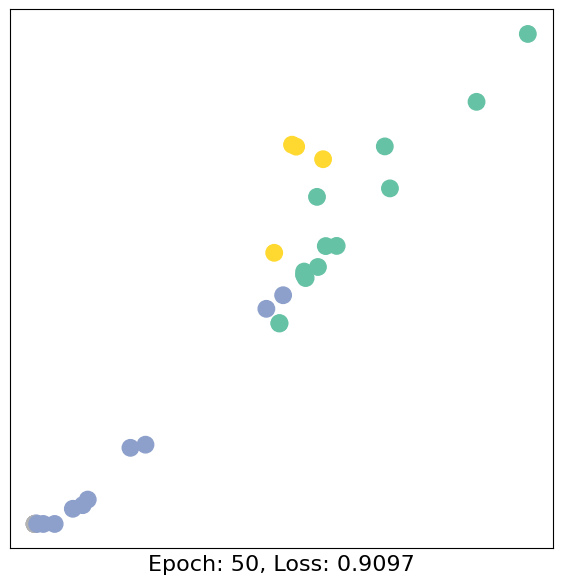

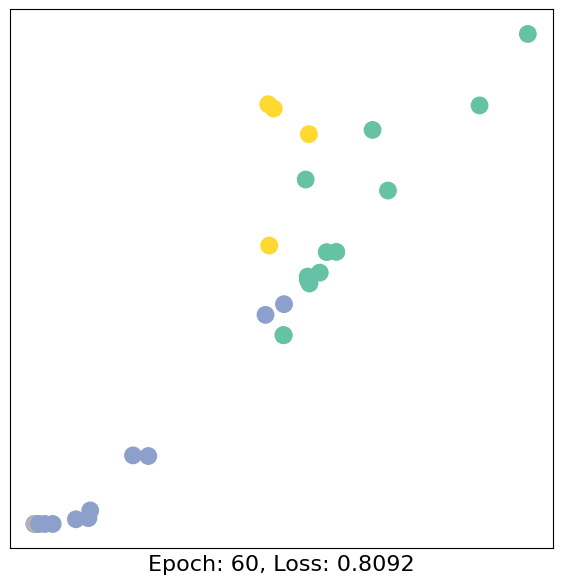

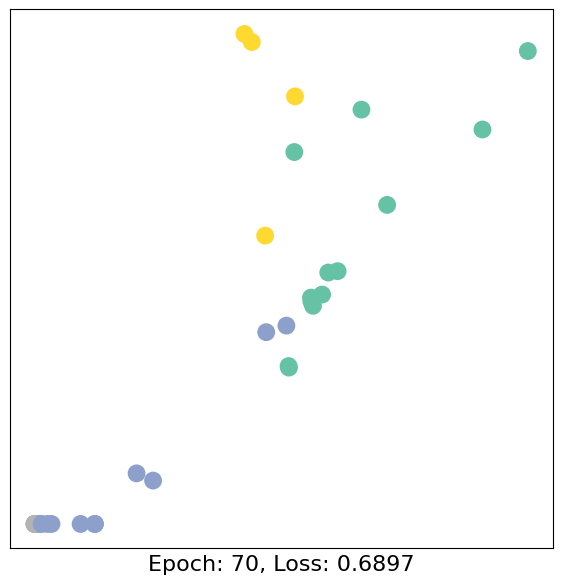

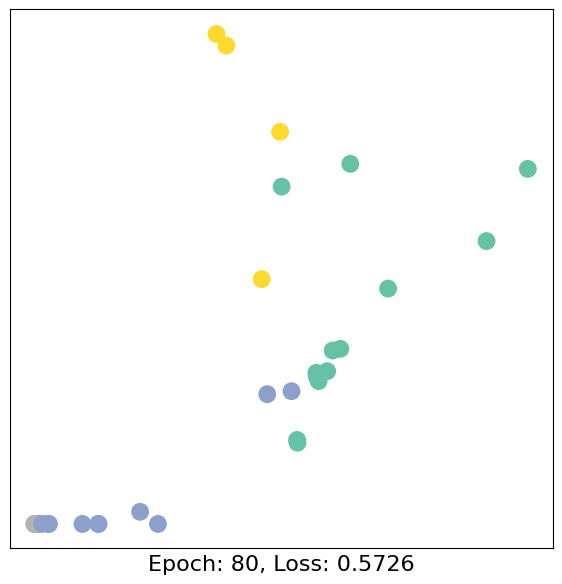

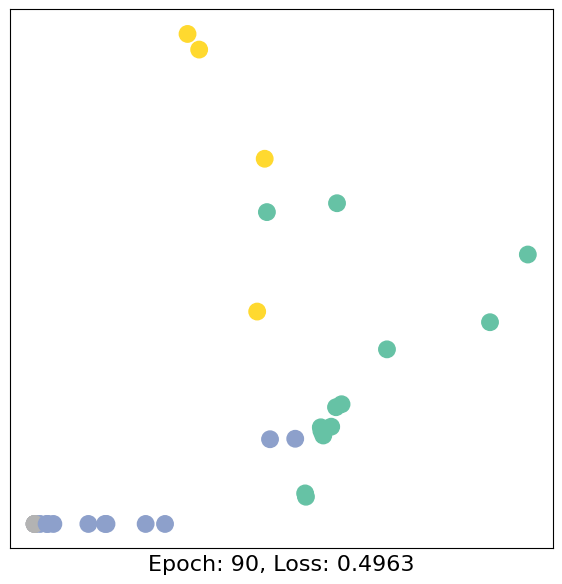

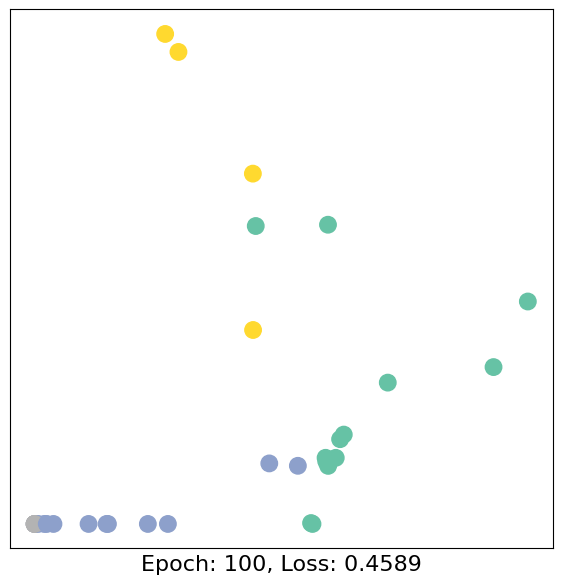

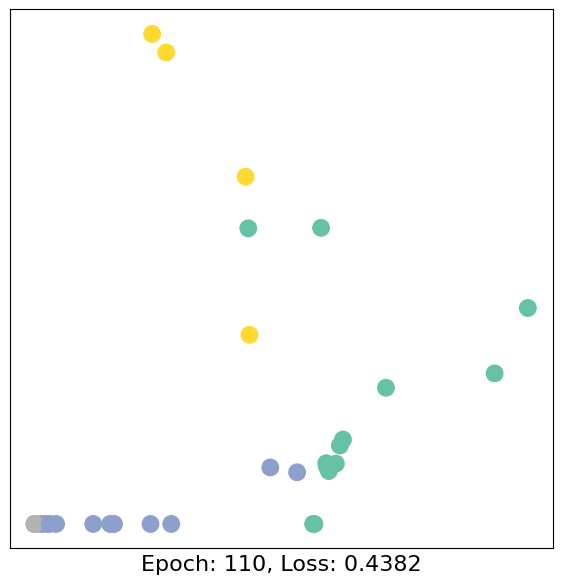

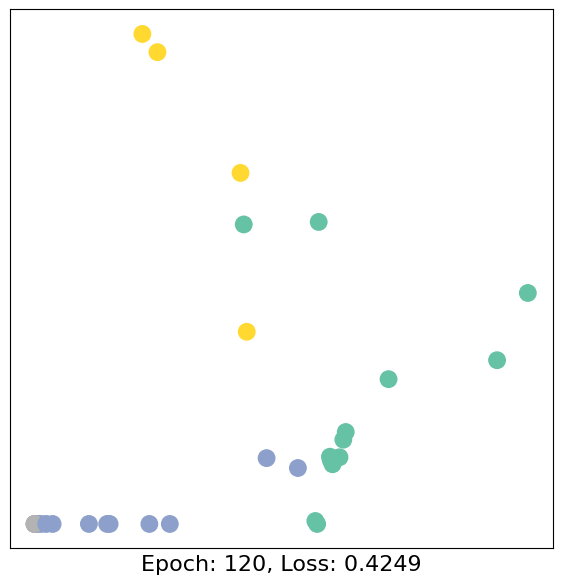

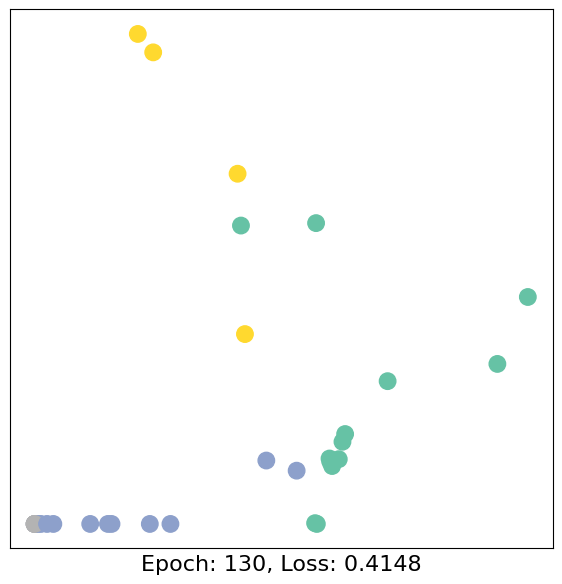

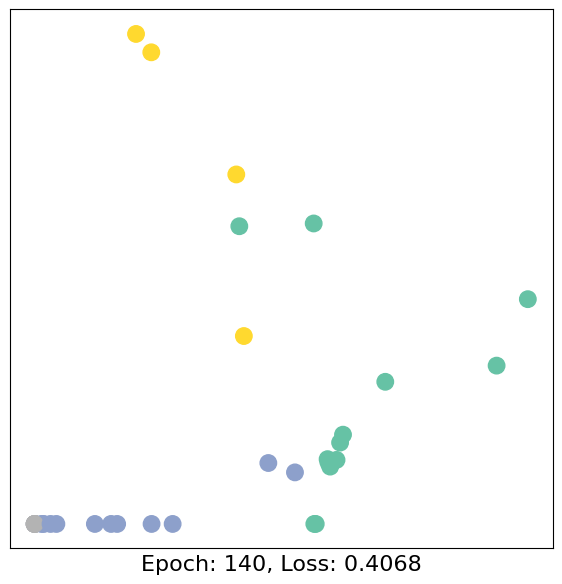

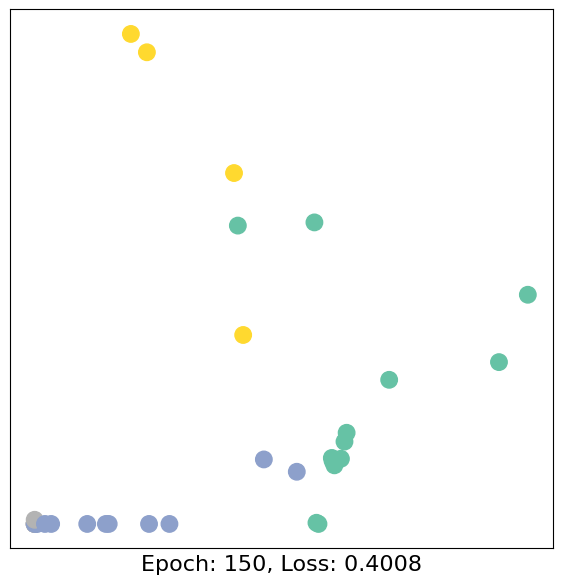

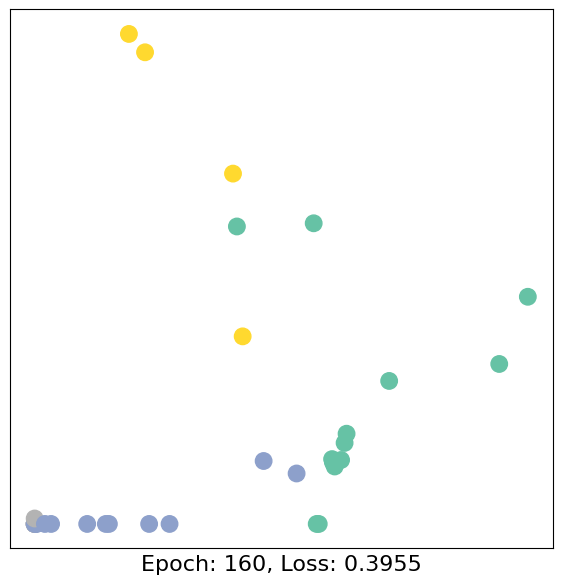

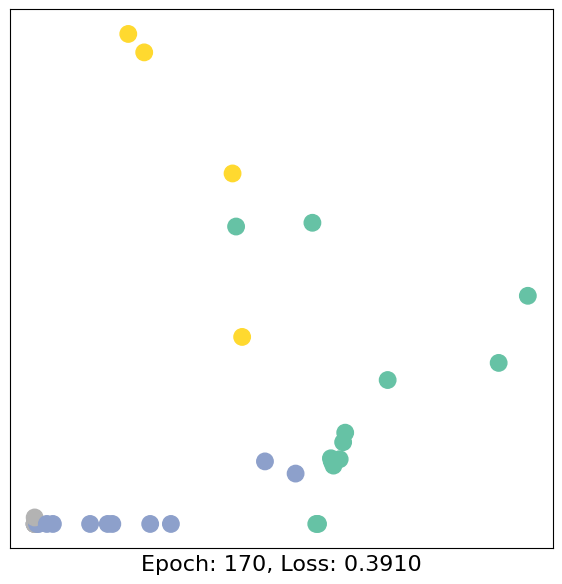

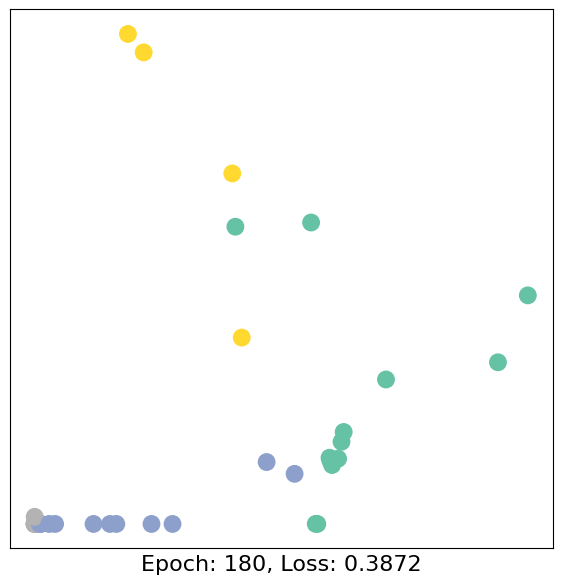

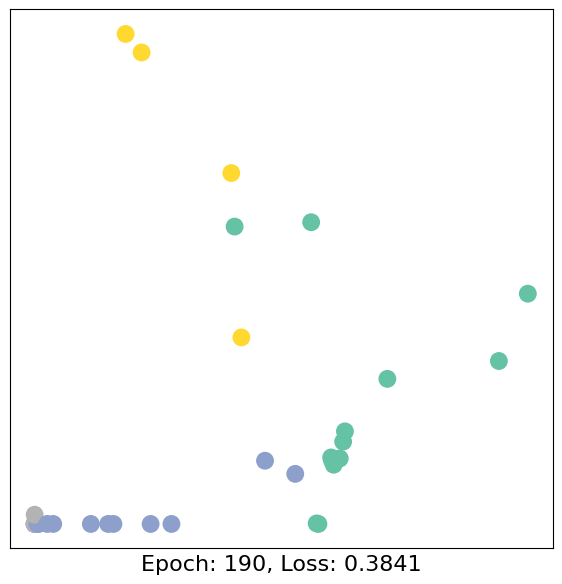

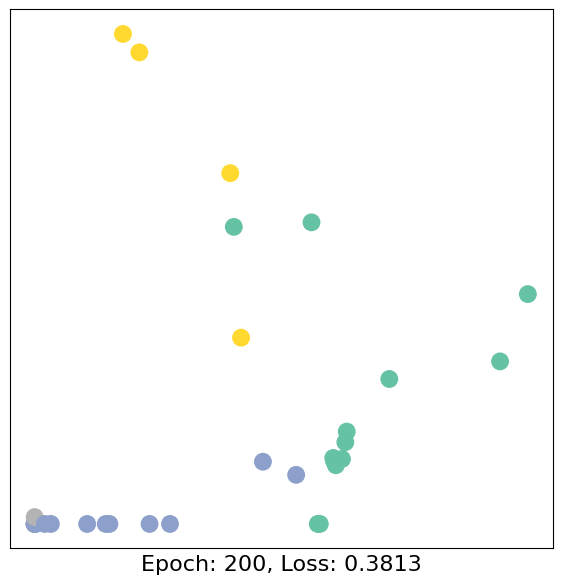

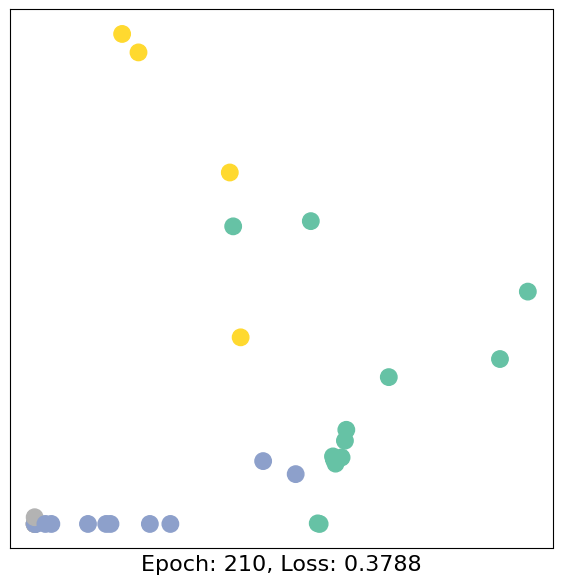

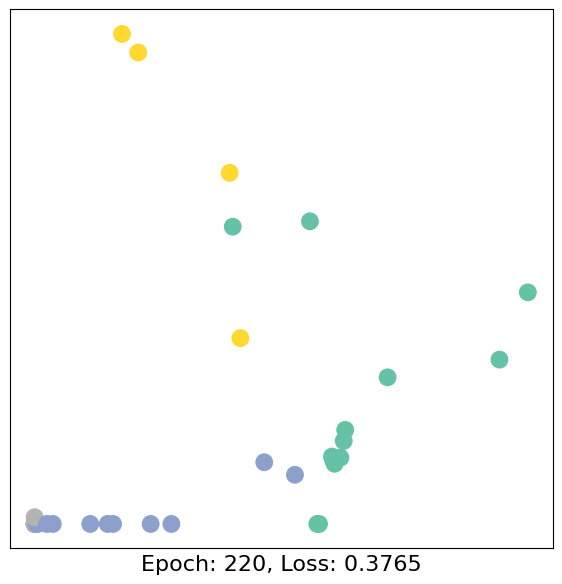

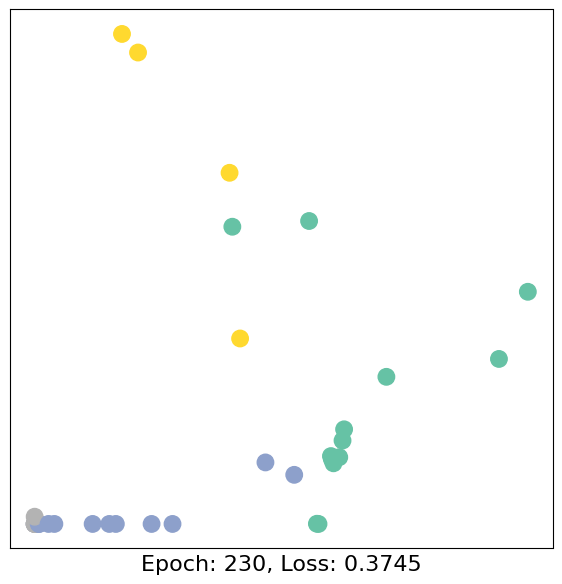

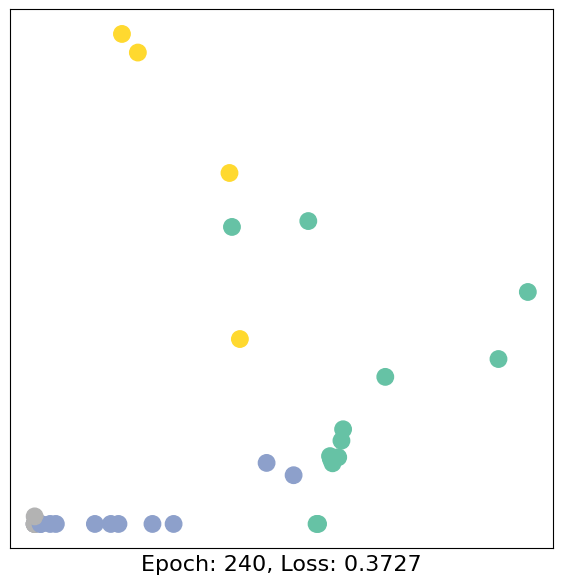

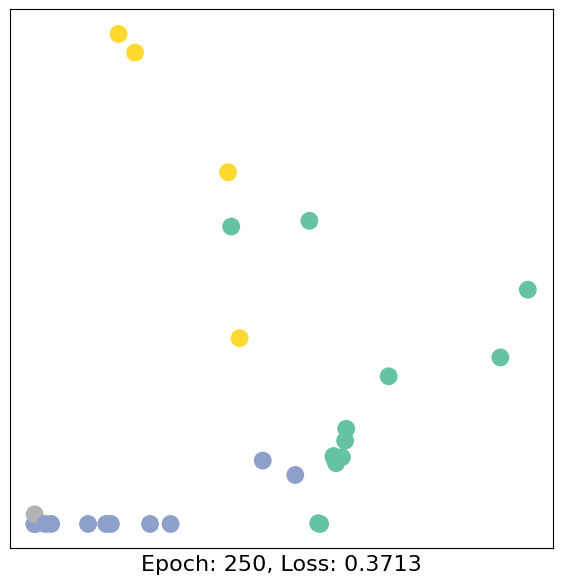

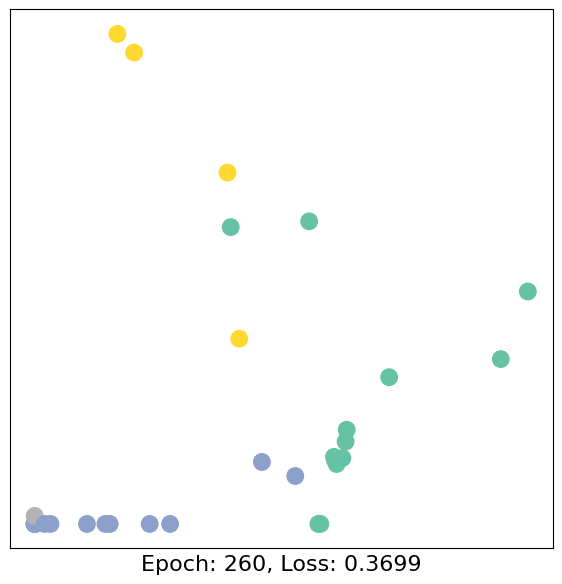

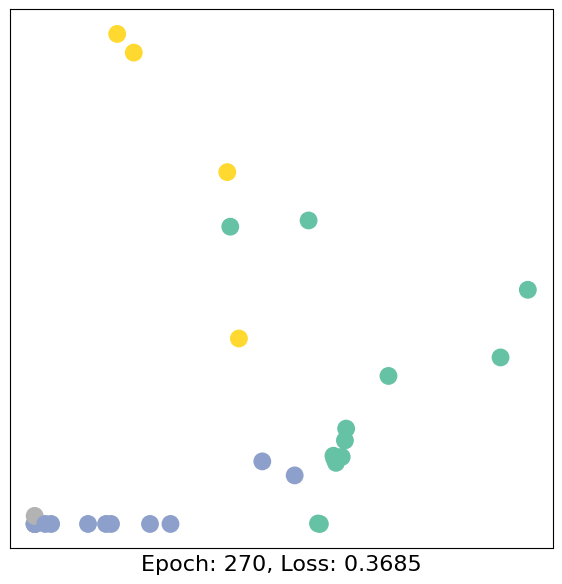

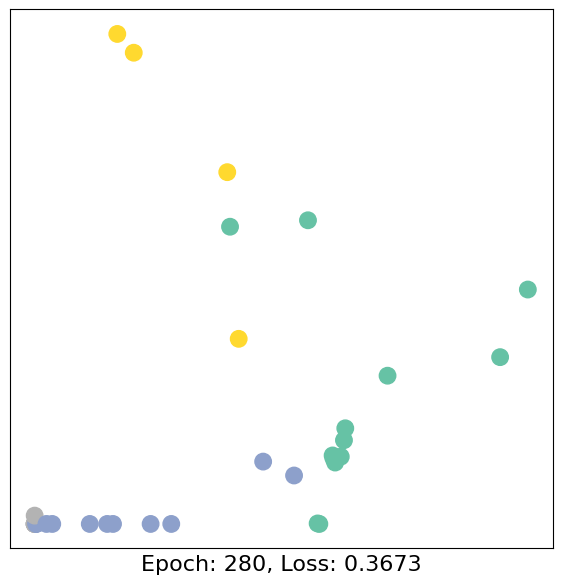

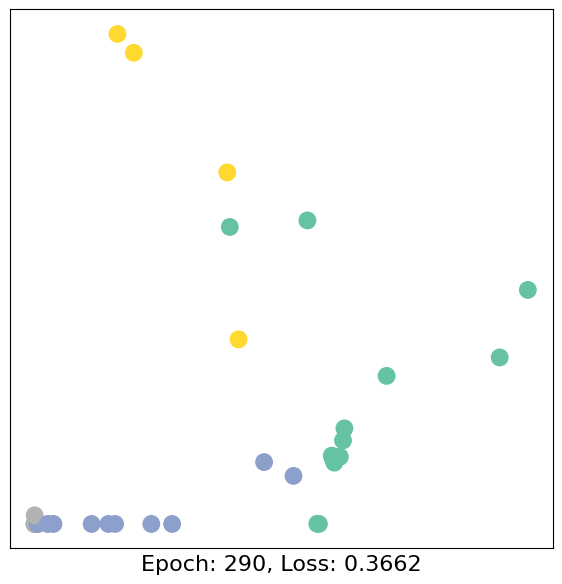

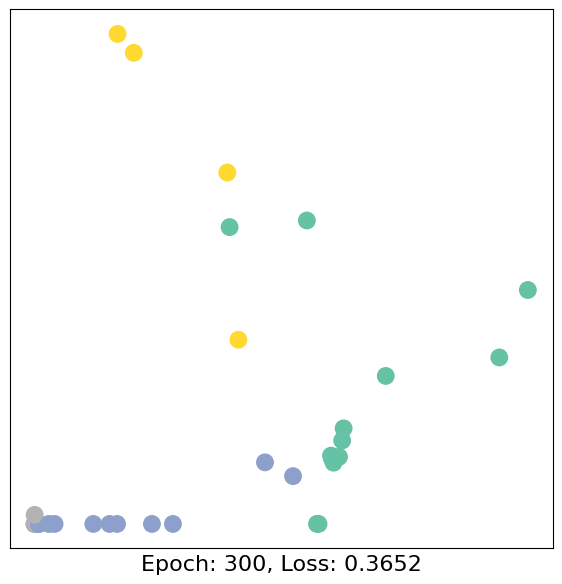

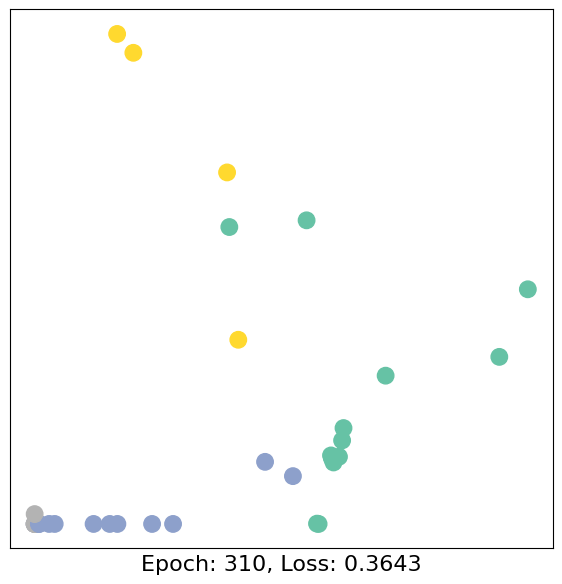

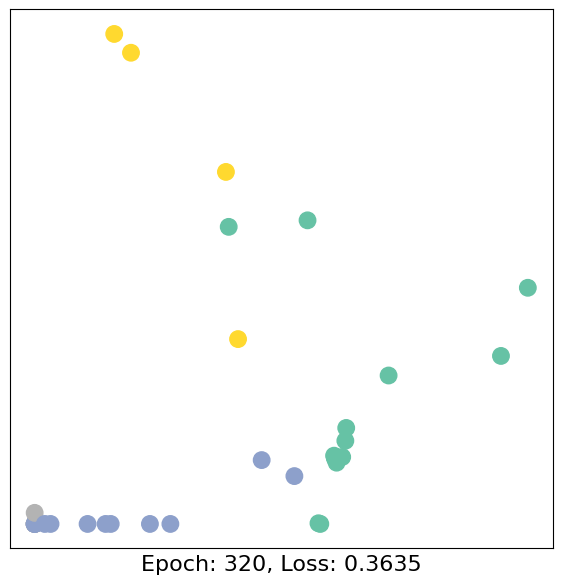

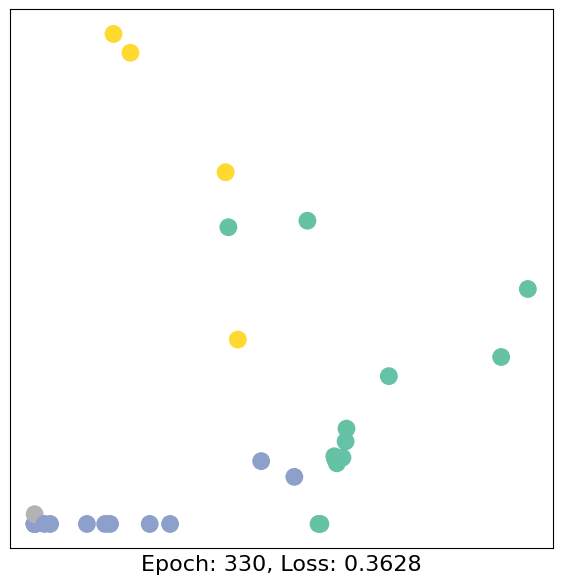

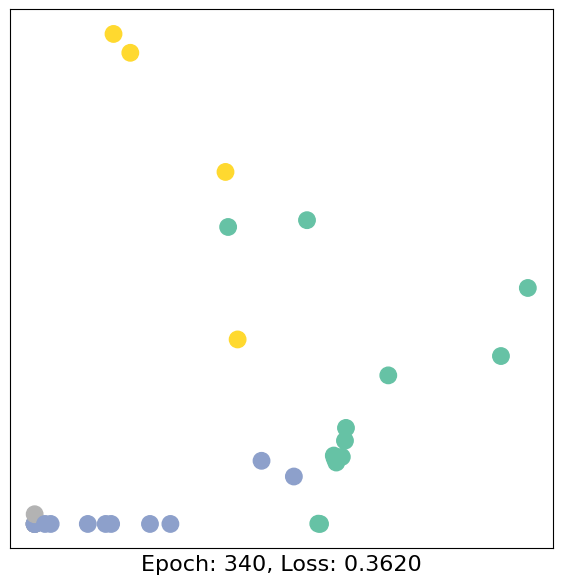

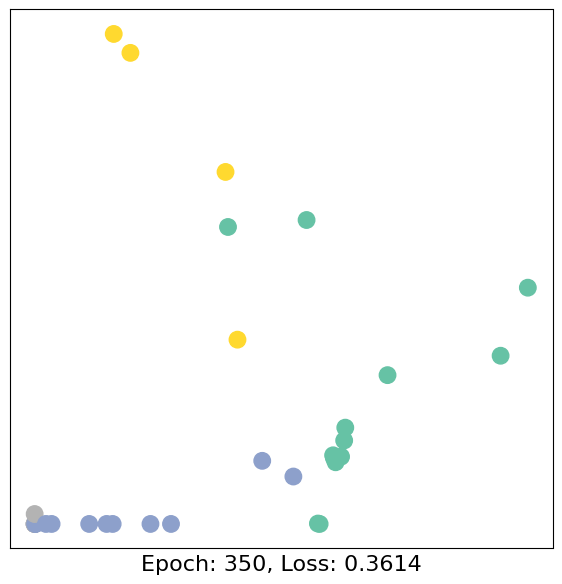

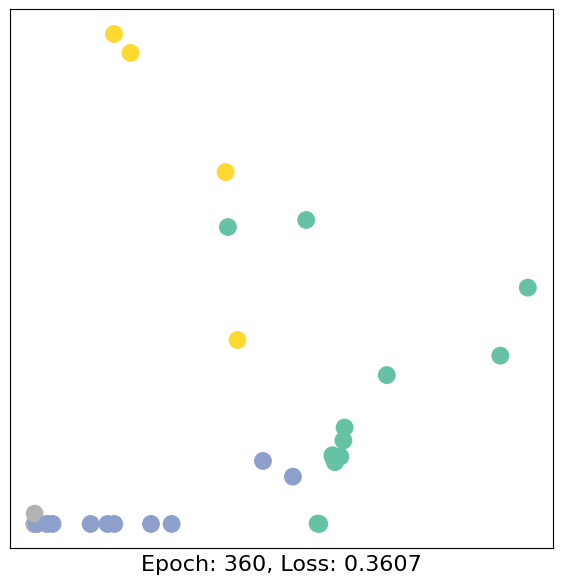

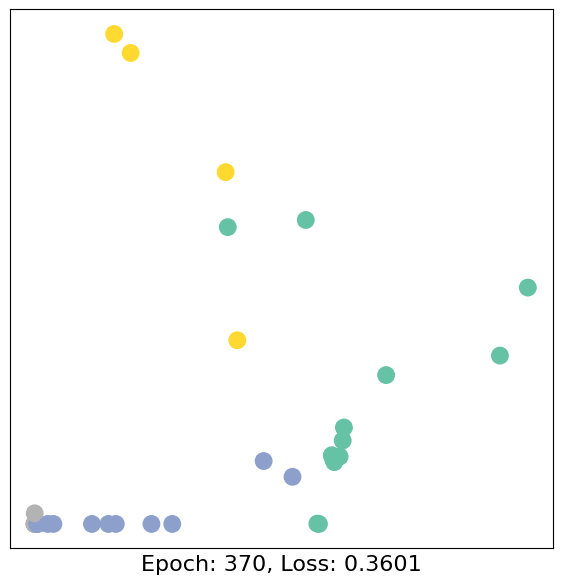

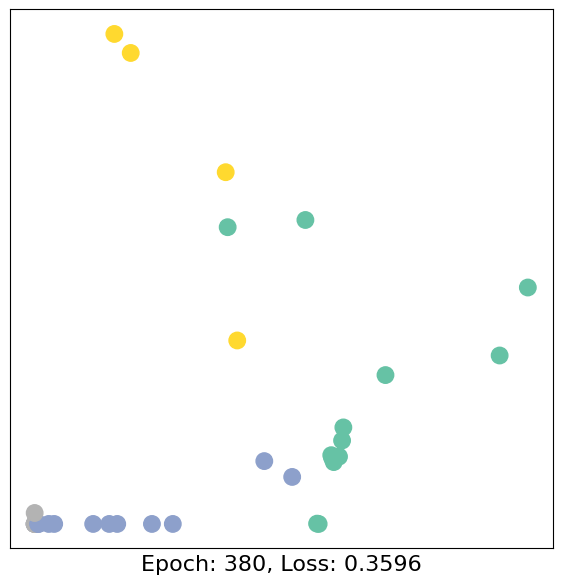

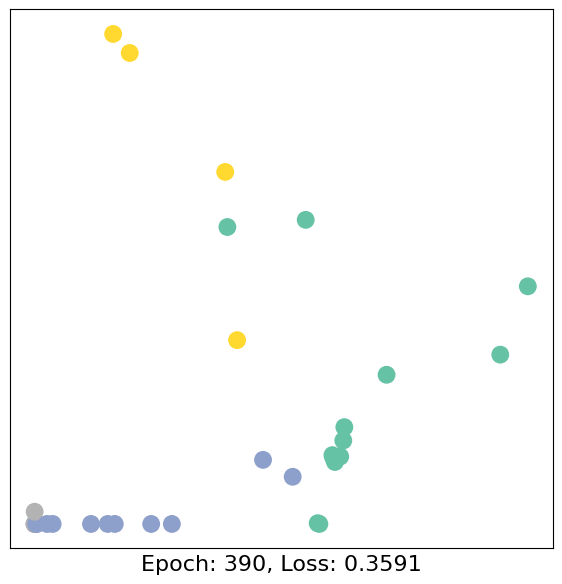

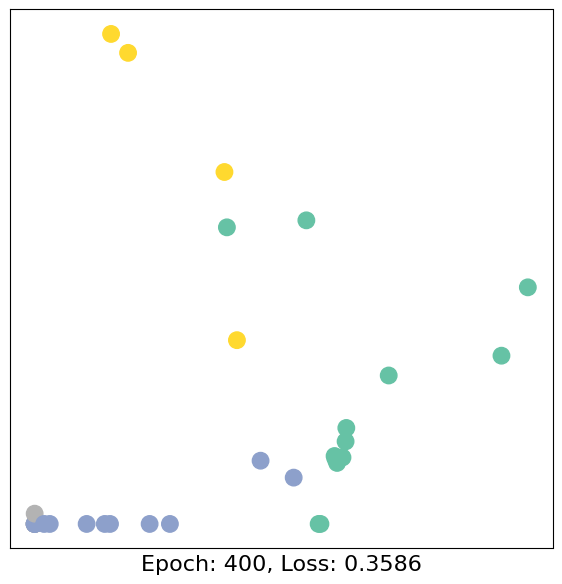

In [ ]:
import time
import matplotlib.pyplot as plt

model_2 = GCN_2()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)  # Define optimizer.

def train(data,model):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

epochs = []
losses = []
for epoch in range(401):
    loss, h = train(data,model_2)
    losses.append(float(loss))
    epochs.append(epoch)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)



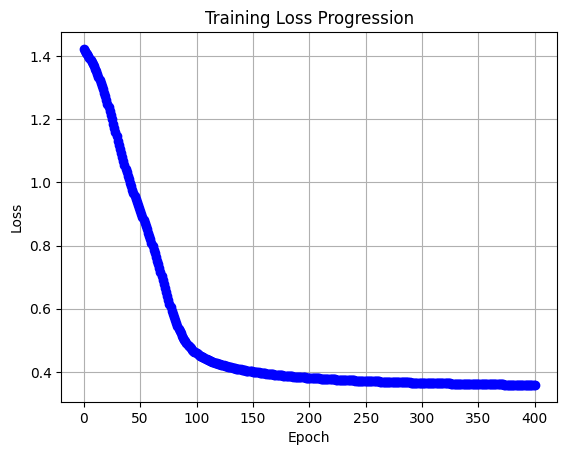

In [ ]:
# Graficar la pérdida en función de las épocas
plt.figure()
plt.plot(epochs, losses, marker='o', color='b')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## **Modelo 3**

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN_3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h



En este caso vamos a utilizar la función de activación tanh() que Aplica la función Tangente Hiperbólica elemento por elemento. (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)

In [ ]:
model_3 = GCN_3()
print(model_3)

GCN_3(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


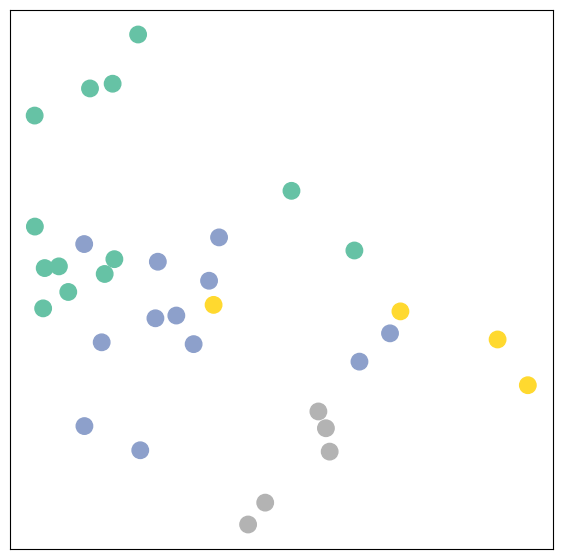

In [ ]:
model_3 = GCN_3()

_, h = model_3(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

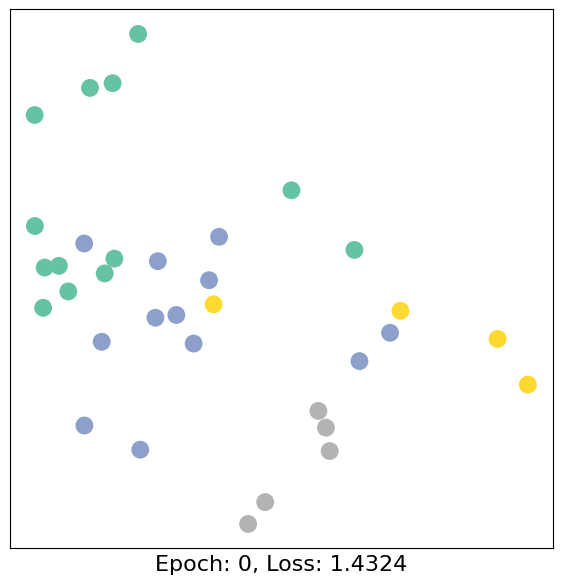

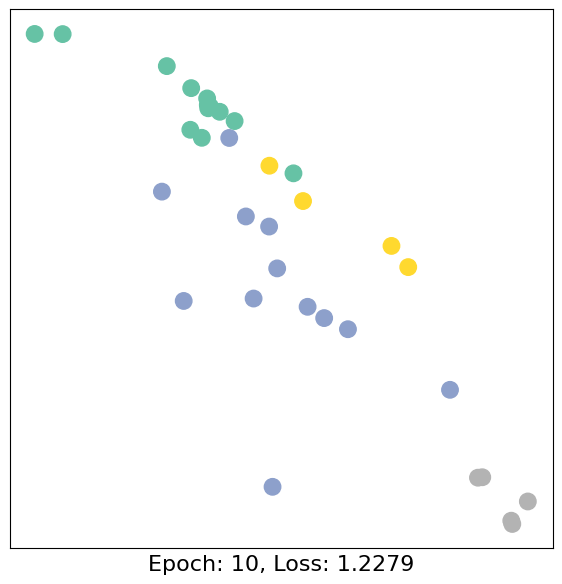

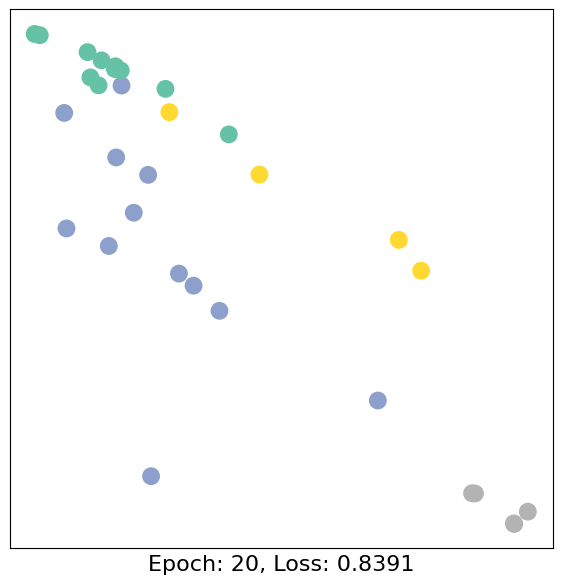

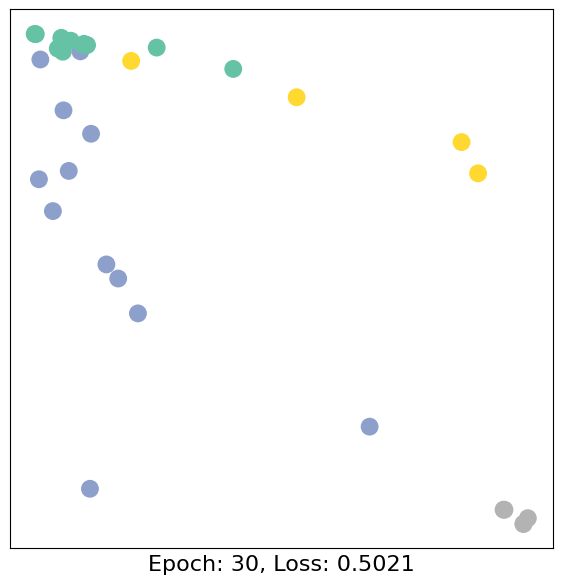

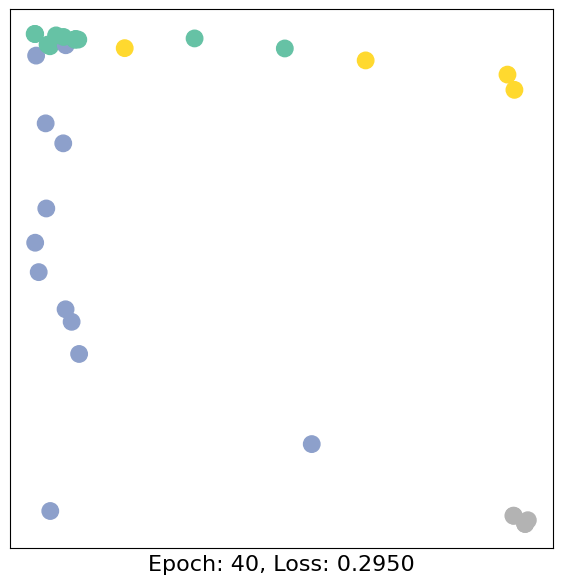

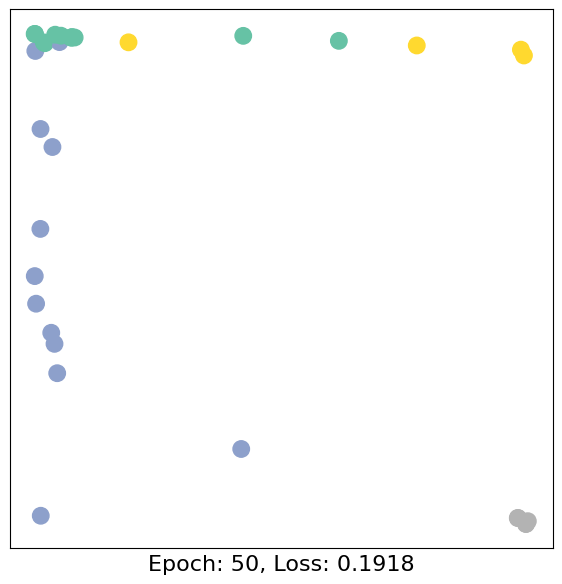

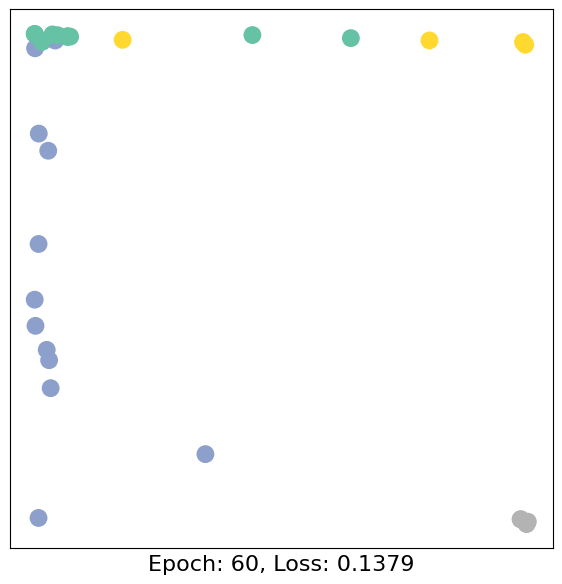

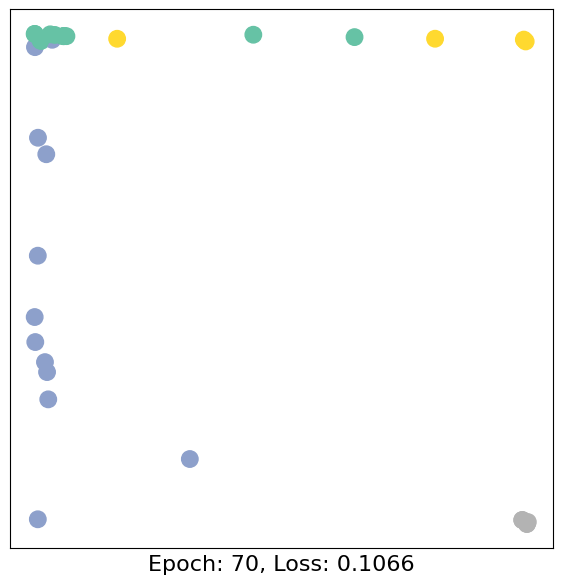

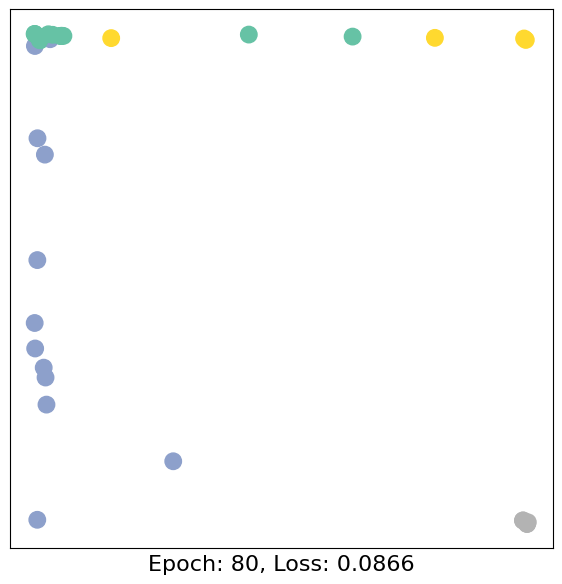

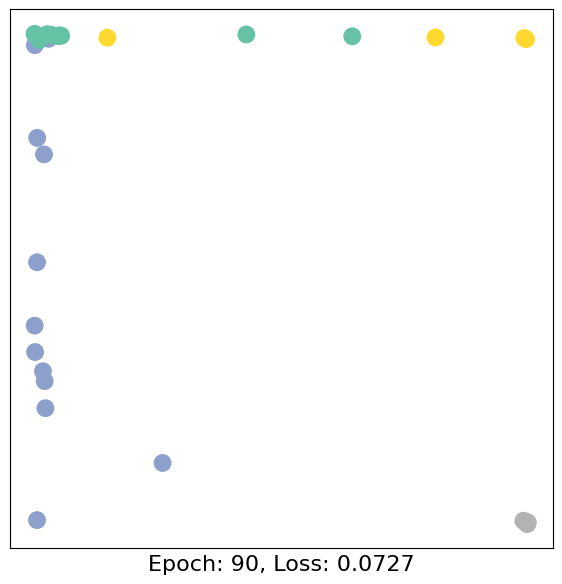

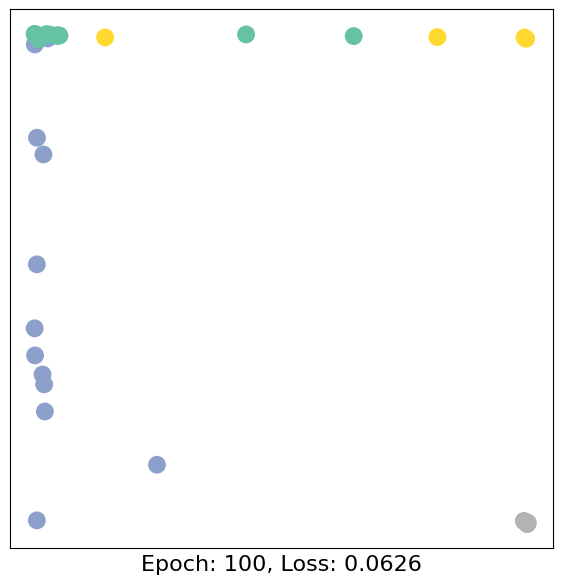

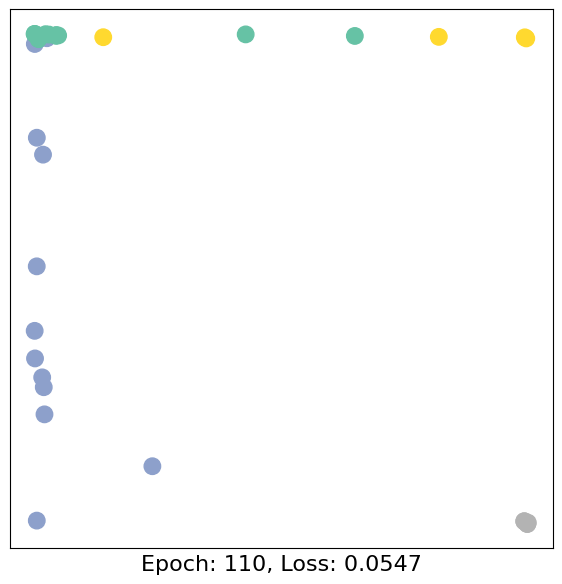

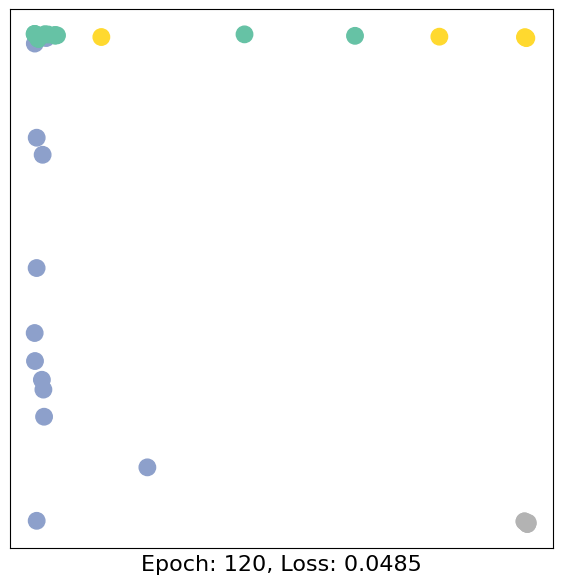

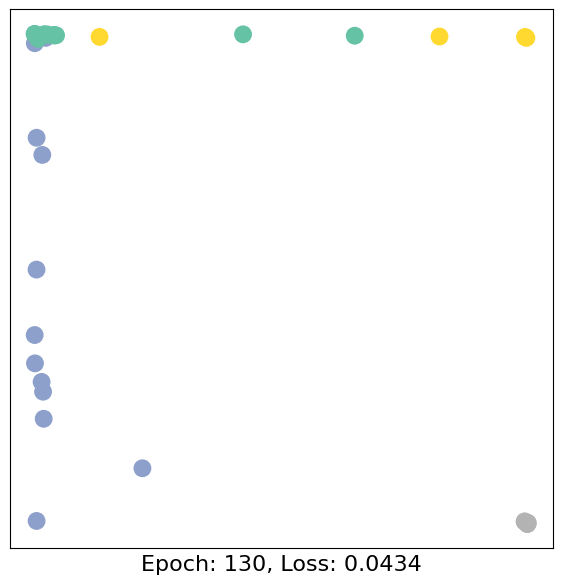

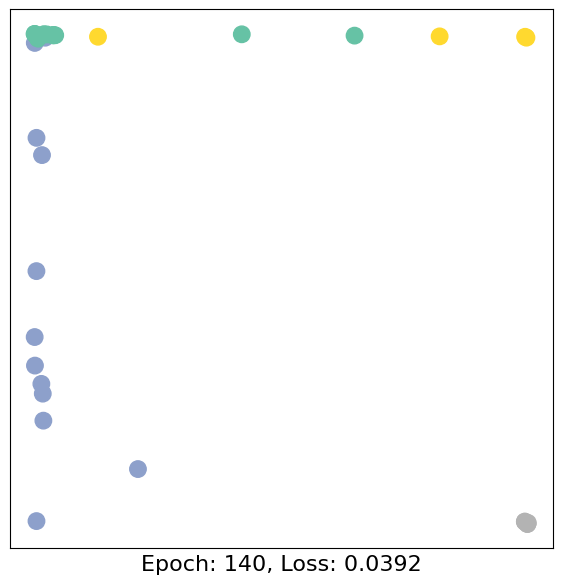

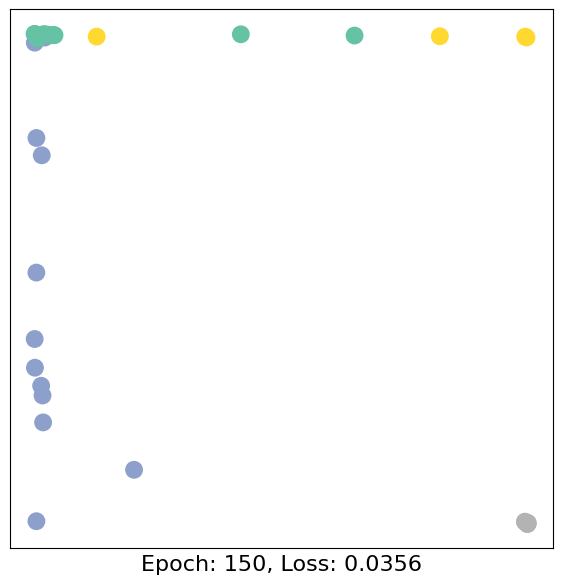

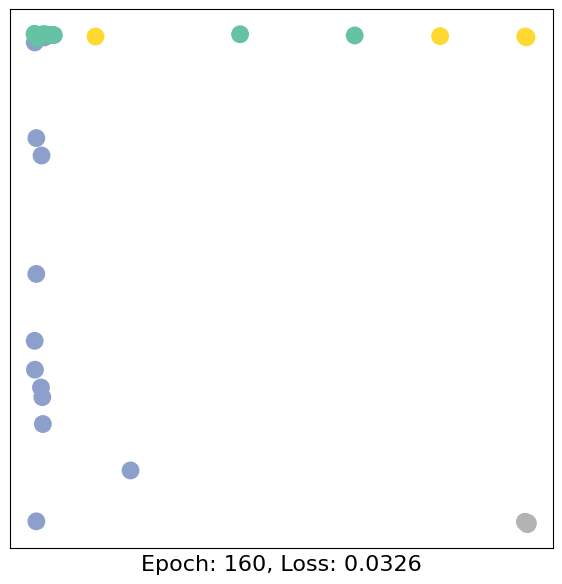

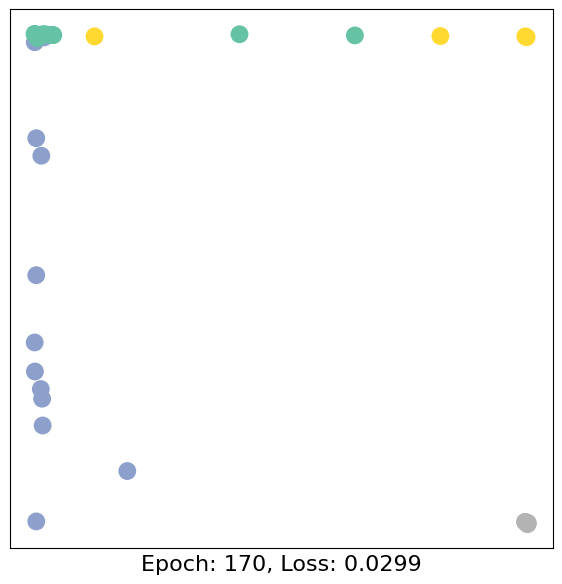

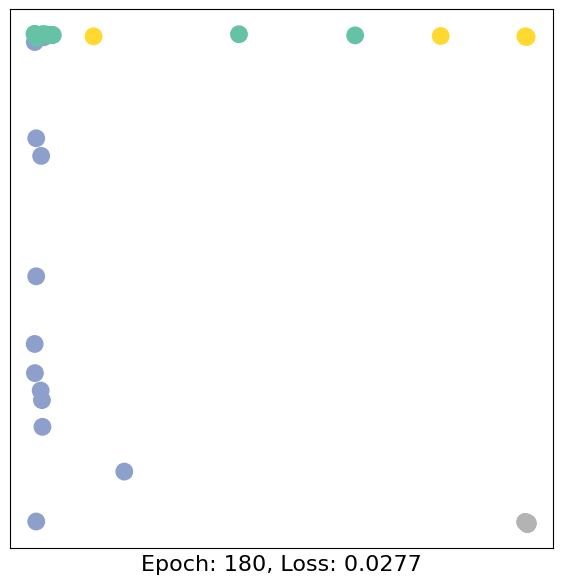

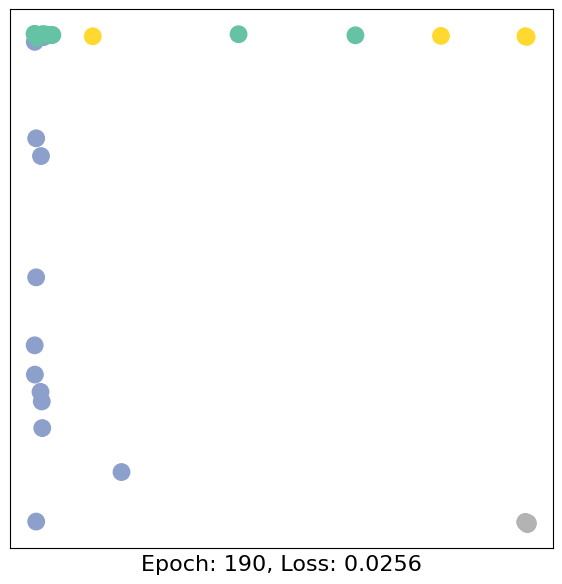

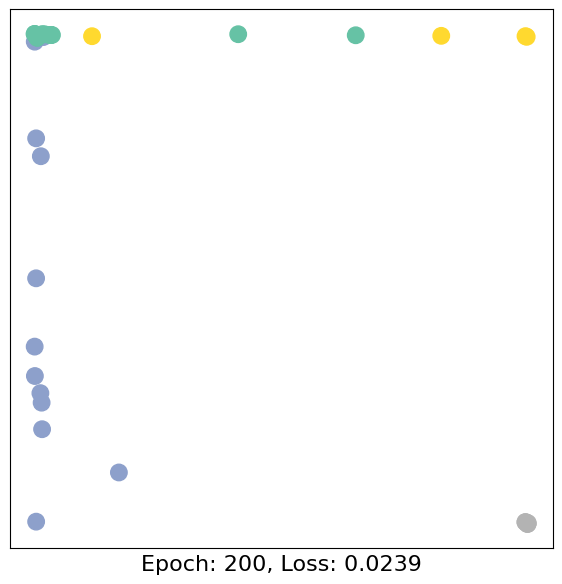

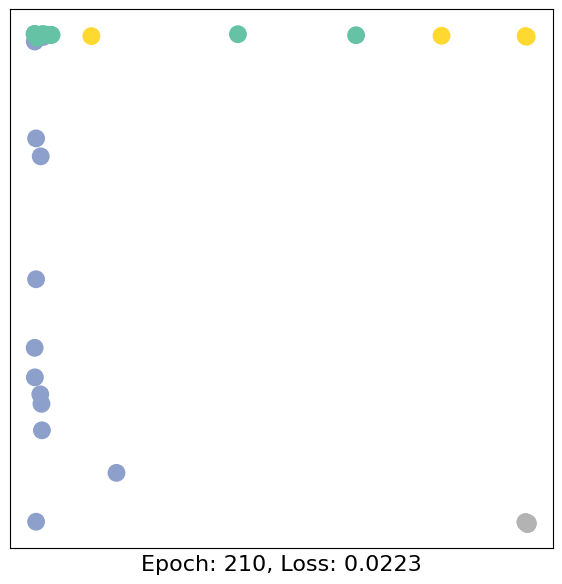

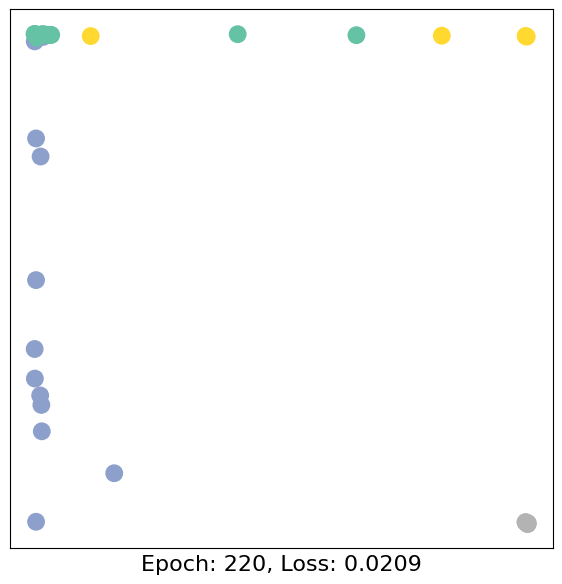

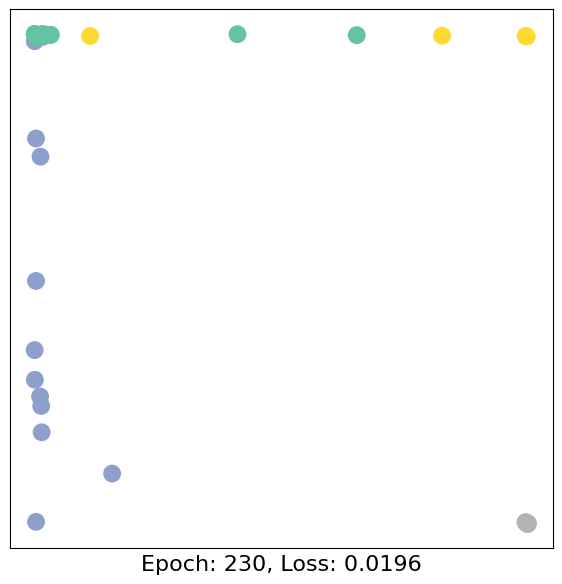

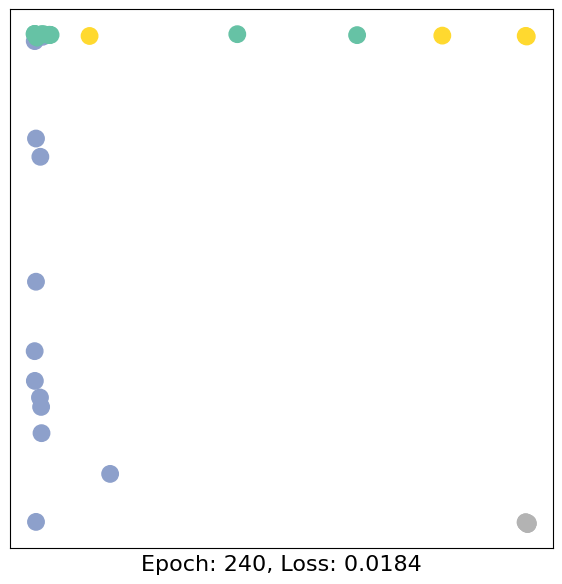

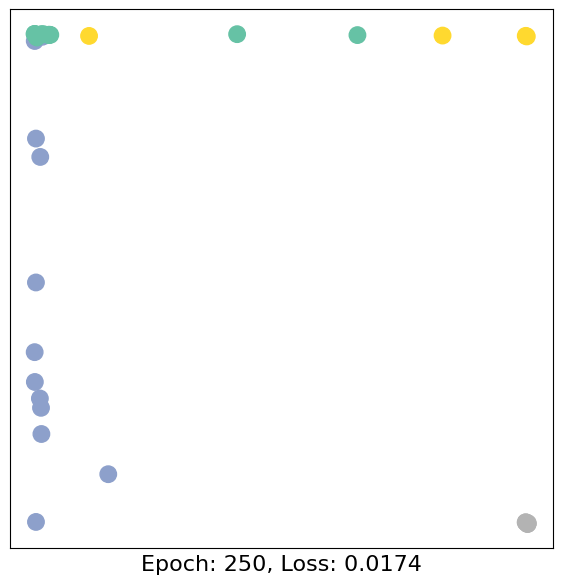

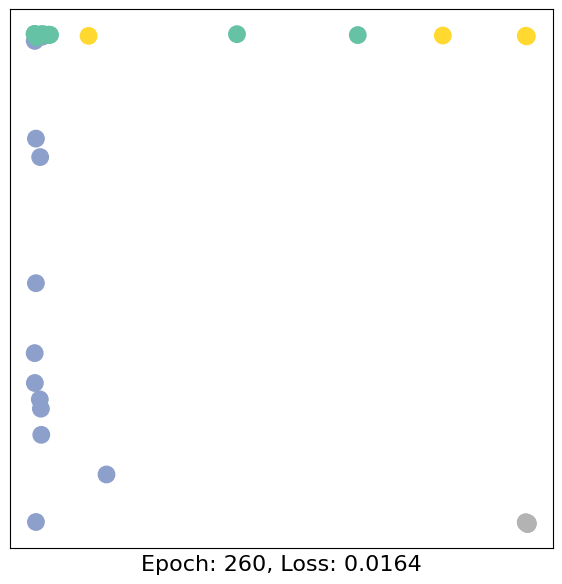

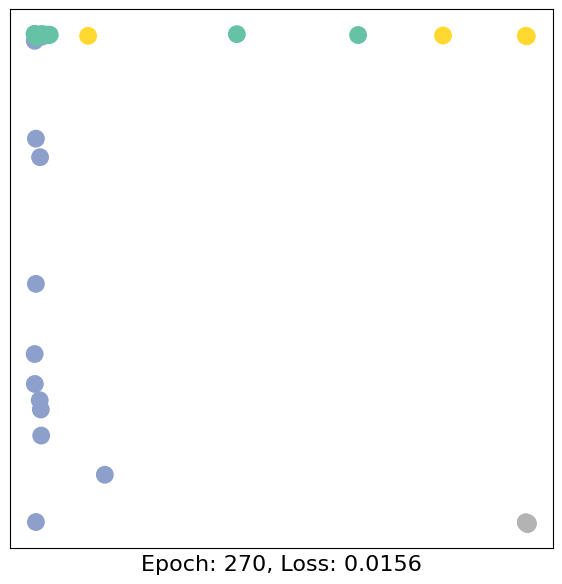

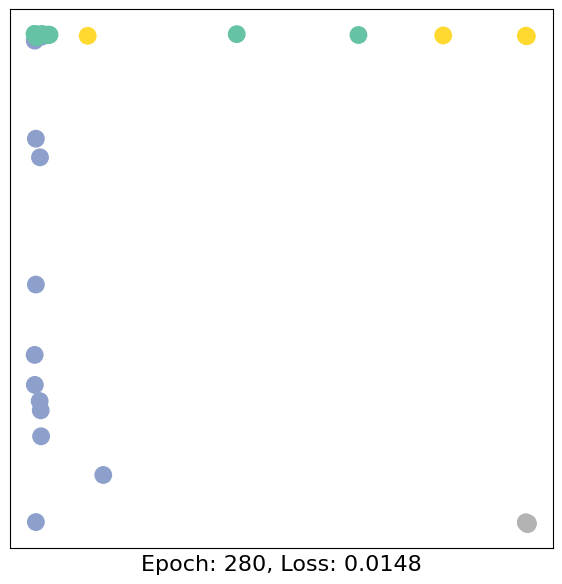

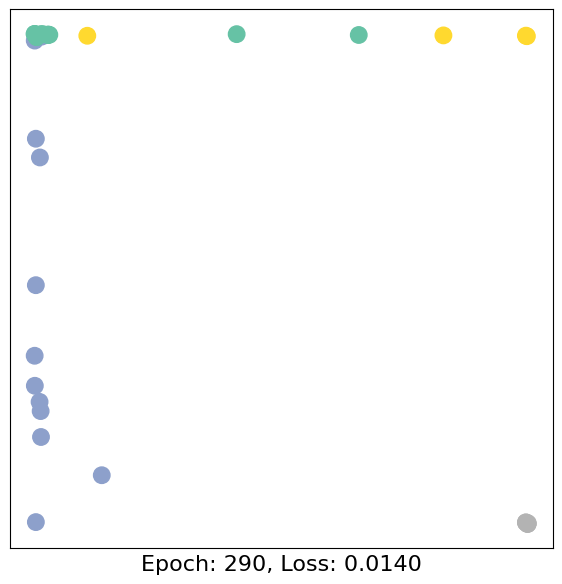

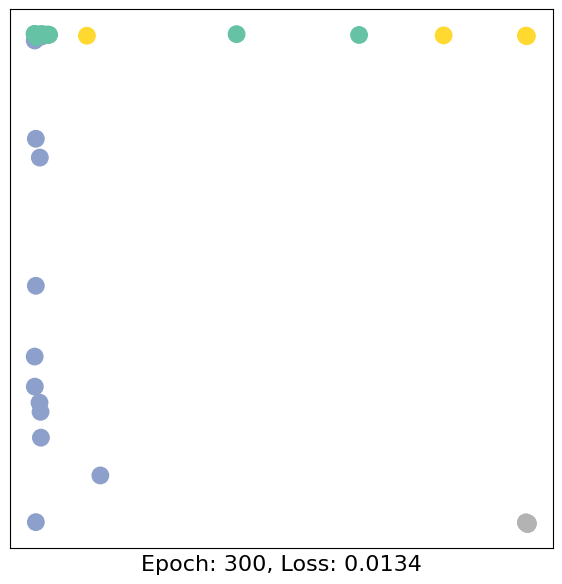

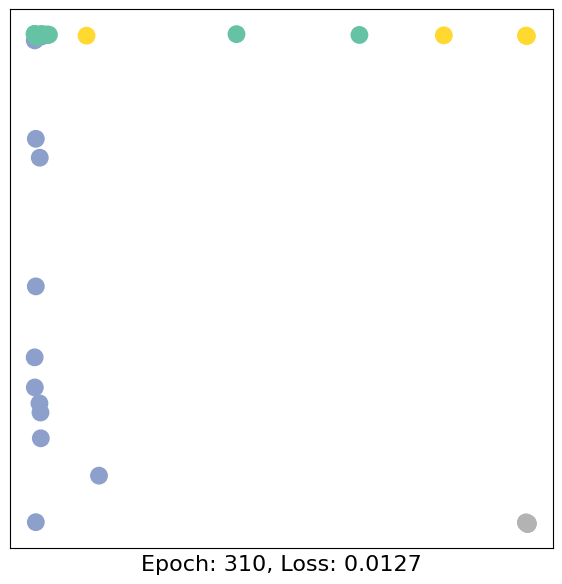

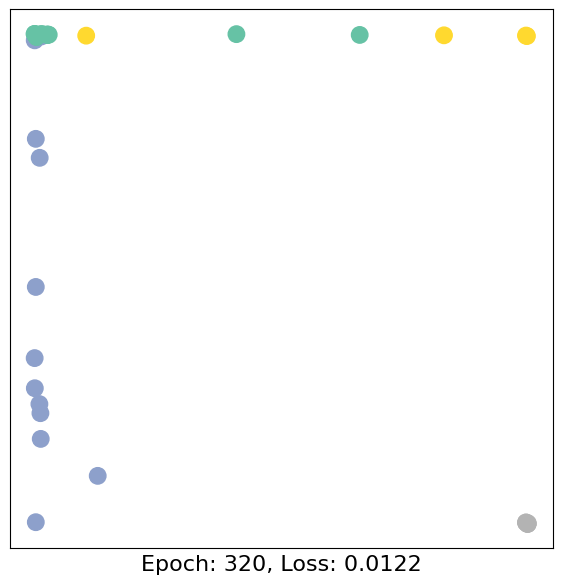

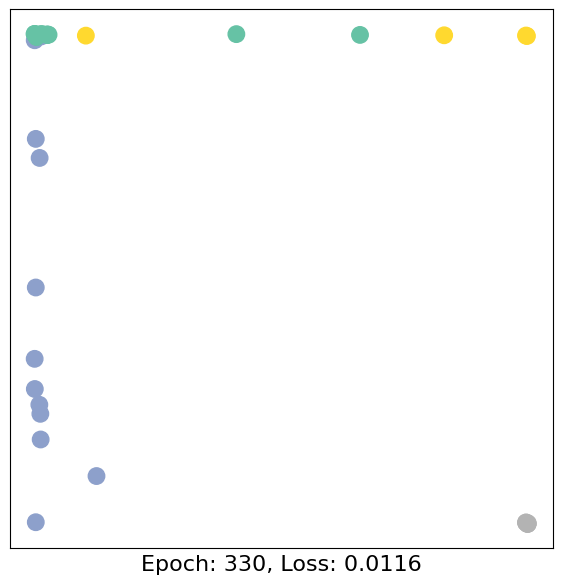

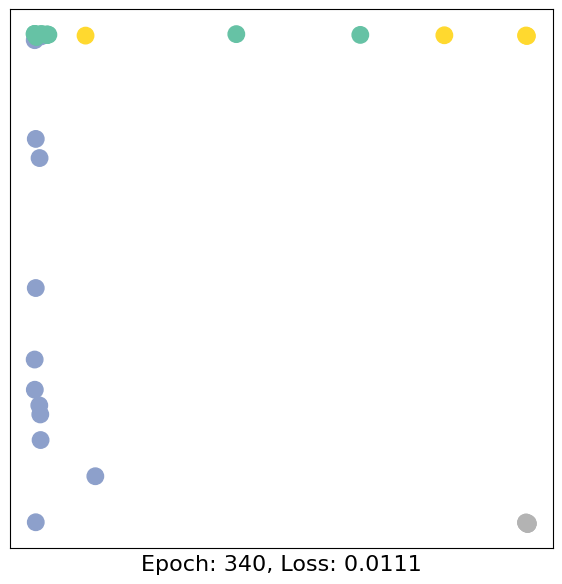

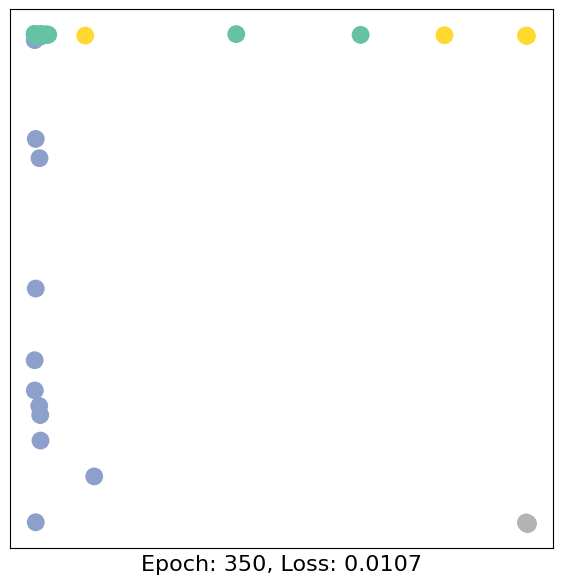

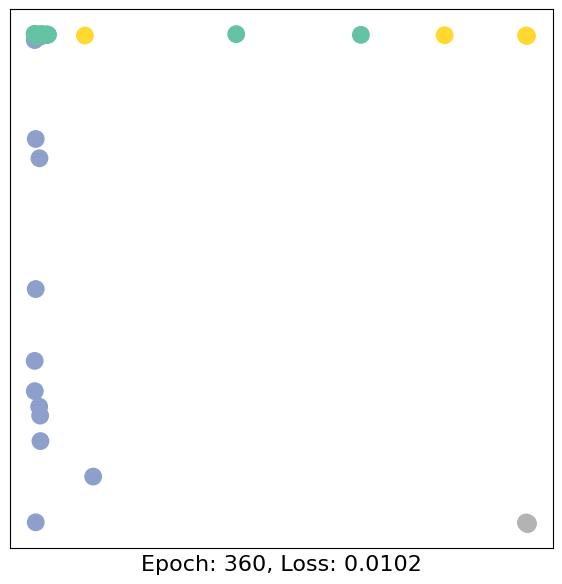

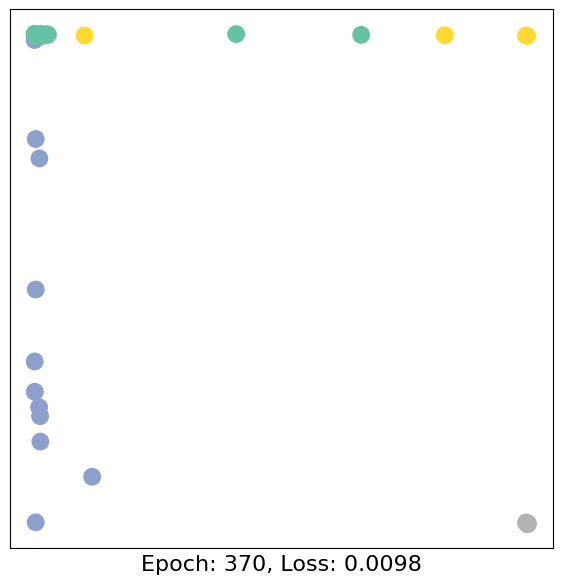

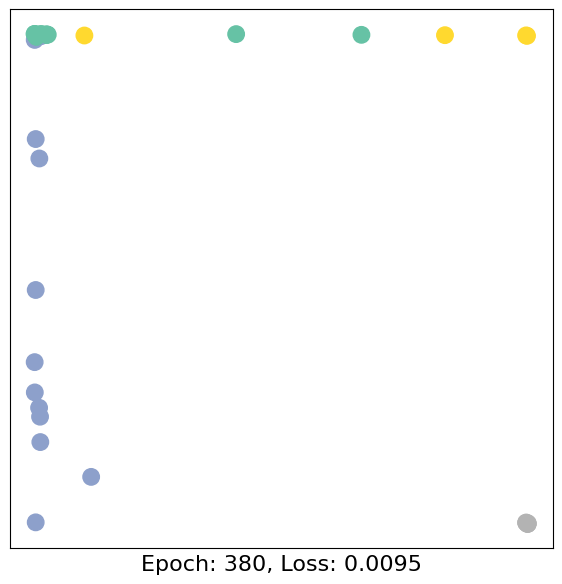

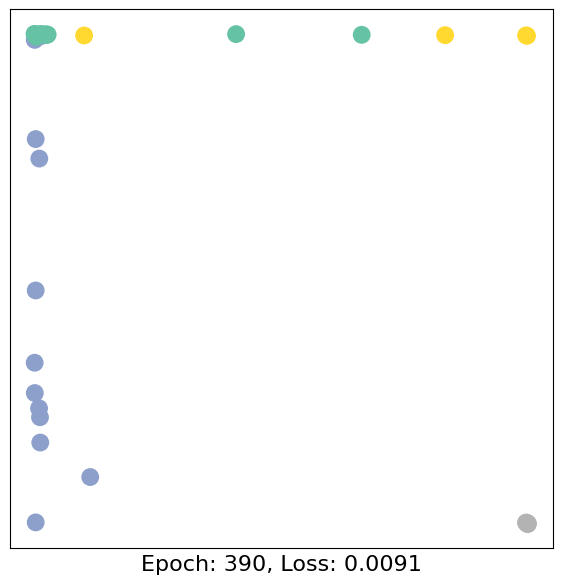

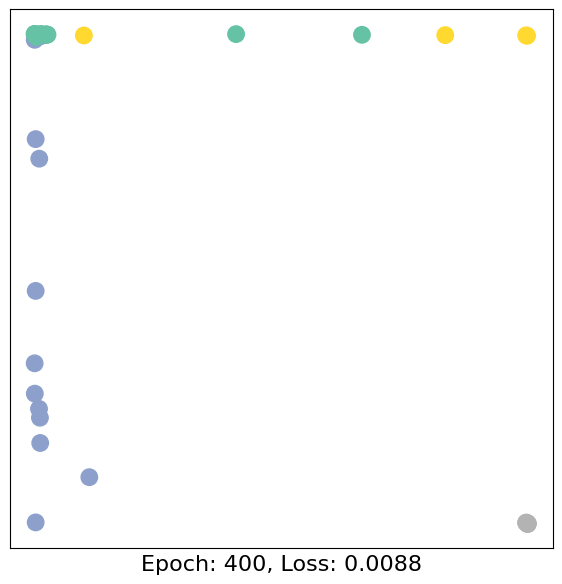

In [ ]:
import time
import matplotlib.pyplot as plt

model_3 = GCN_3()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)  # Define optimizer.

def train(data,model):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

epochs=[]
losses = []
for epoch in range(401):
    loss, h = train(data,model_3)
    epochs.append(epoch)
    losses.append(float(loss))
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)


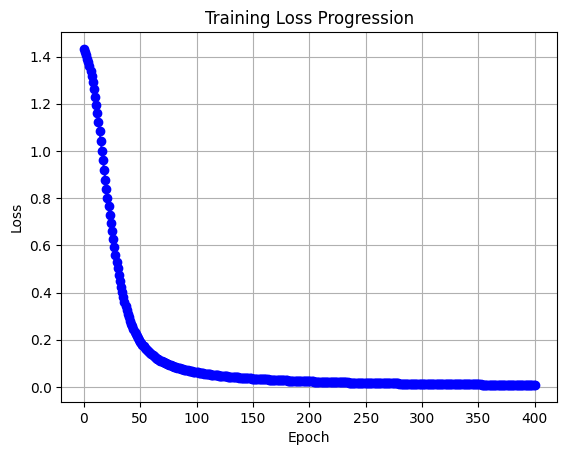

In [ ]:
# Graficar la pérdida en función de las épocas
plt.figure()
plt.plot(epochs, losses, marker='o', color='b')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## **Actividades**


##*   Agregar más capas al modelo. ¿Se logra mejorar la predicción?
##*   ¿Si utilizamos otros opciomizadores como SGD podriamos mejorar los resultados?
##*   Modificar el Learning rate (lr) del optimizador y verificar si el modelo mejora
##*   En base a los resultados, ¿Es necesario utilizar muchas epocas de entrenamiento? ¿Se podría utilizar menos?


